<a href="https://colab.research.google.com/github/romulobrito/iri_ML/blob/master/iri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Índice Internacional de Irregularidade (IRI) - International Roughness Index

## 1. Introdução
O Índice Internacional de Irregularidade (IRI) é um parâmetro amplamente utilizado para medir a irregularidade superficial das rodovias. Ele é fundamental para avaliar o conforto e a segurança dos usuários, além de ser um critério de desempenho exigido em concessões rodoviárias. Este notebook tem como objetivo documentar e estruturar a análise do IRI com base nos documentos de referência e observações encontradas na exploração dos dados disponibilizados.

## 2. Descrição do Dado
O IRI é uma métrica que quantifica a irregularidade longitudinal de uma via. Ele é expresso em metros por quilômetro (m/km) e pode ser obtido através de medições realizadas com perfilômetros a laser, veículos instrumentados ou outros equipamentos de monitoramento rodoviário.

### Principais características do IRI:
- Unidade de medida: m/km.
- Classificação da irregularidade: quanto maior o valor do IRI, pior a condição da superfície da rodovia.
- Padrão internacional utilizado para avaliar a qualidade do pavimento.
- Possui impacto direto na segurança viária e no conforto dos usuários.

## 3. Referência no PER e no Manual de Fiscalização

### 3.1. O que os documentos regulatórios dizem sobre o IRI?

#### **PER - Ecovias do Araguaia**
O Programa de Exploração da Rodovia (PER) define limites específicos para o IRI em diferentes estágios da concessão:
- **Recuperação**: IRI máximo permitido de 3,5 m/km em segmentos específicos
- **Manutenção**: Redução progressiva do IRI ao longo dos anos da concessão
- **Recebimento final da concessão**: IRI máximo permitido de 2,7 m/km em toda a extensão da rodovia

#### **Manual de Fiscalização de Rodovias Federais Concedidas**
- O manual estabelece também critérios para medições do IRI, frequência das avaliações e diretrizes para ações corretivas quando os valores ultrapassam os limites aceitáveis.
- Requer que as concessionárias implementem medidas para garantir a conformidade do IRI com os padrões estabelecidos.

## 4. Metodologia de Fiscalização Sistêmica

Para verificar o cumprimento dos parâmetros do IRI de forma automatizada, o sistema de fiscalização pode seguir os seguintes passos:
1. **Coleta de Dados**: Utilização de sensores de perfilometria a laser para medir a irregularidade da pista.
2. **Processamento e Cálculo**: Conversão dos dados brutos em valores de IRI utilizando algoritmos padronizados.
3. **Comparação com Regulamentação**: Os valores obtidos são comparados com os limites estabelecidos no PER de acordo com o estágio de concessão.
4. **Geração de Alertas**: Se valores superiores ao permitido forem identificados (e ultrapassarem também o erro aceitável, que usualmente é 10%, também descrito no PER), alertas são gerados.
5. **Sugestão de Intervenções**: Identificação de anomalias ou trechos críticos que necessitam de manutenção corretiva.

## 5. Exploração e Análise dos Dados
**Esta seção trata-se de análises práticas dos dados disponíveis, incluindo estatísticas descritivas, gráficos e comparações com os limites regulamentares.**

O parâmetro de desempenho Índice Internacional de Irregularidade (IRI) tem sua unidade de medida como m/km, que está relacionada diretamente com a posição dos trechos quilométricos, então, uma das principais formas que o parâmetro pode ser visualizado para análises é através do plot de IRI Médio (m/km) por Posição (km), com o respectivo limite estabelecido do PER incluso, como o exemplo a seguir:

<img src="https://github.com/romulobrito/iri_ML/blob/master/Plots/IRI%20M%C3%A9dio%20por%20Quil%C3%B4metro%20(BR-080GO%20-%20km%2094,35%20-%20km%20181,070%20-%20Faixa%201%20-%20Sentido%20Crescente).png?raw=1" alt="IRI Médio por Quilômetro (BR-080GO - km 94,35 - km 181,070 - Faixa 1 - Sentido Crescente)" />

Com essa forma de visualização, como no exemplo acima da BR-080GO (km 94,35 - km 181,070 - Faixa 1 - Sentido Crescente) é possível relacionar os respectivos IRIs com suas posições quilométricas, de tal forma que o levantamento de alertas ou detecção de anomalias tornam-se visualmente simples.

Os alertas podem ser visualizados a partir dos picos que possivelmente se sobressaírem dos respectivos limites temporais (estabelecidos no PER) — como no exemplo do gráfico acima de IRI Médio por Quilômetro da BR-080GO é possível observar um pico notável se sobressaindo no km 122,200 — cabendo assim uma análise se os picos sobressalentes ultrapassam também o erro aceitável (que usualmente é 10%, também descrito no PER).

In [ ]:
!pip install "pandas[excel]" seaborn matplotlib folium branca
!git clone https://github.com/romulobrito/iri_ML.git
%cd iri_ML

Cloning into 'iri_ML'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 58 (delta 17), reused 46 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 12.54 MiB | 8.40 MiB/s, done.
Resolving deltas: 100% (17/17), done.
/content/iri_ML/iri_ML/iri_ML


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
import numpy as np
import warnings
import os

In [ ]:

def carregar_excel(caminho_arquivo, sheet_name=0):
    """
    Carrega um arquivo Excel sem definir header para facilitar a busca do termo "IRI Médio".

    Parâmetros:
        caminho_arquivo: caminho para o arquivo Excel
        sheet_name: nome ou índice da planilha a ser carregada.
                    Use None para carregar todas as planilhas.

    Retorna:
        Se sheet_name for um índice ou nome: retorna um DataFrame
        Se sheet_name for None: retorna um dicionário de DataFrames, um para cada planilha
    """
    warnings.simplefilter("ignore")  # Esconde avisos do openpyxl
    return pd.read_excel(caminho_arquivo, header=None, sheet_name=sheet_name)

def encontrar_header(df, termo="IRI Médio", ocorrencia=1):
    """
    Encontra dinamicamente a célula onde está localizado o termo desejado no DataFrame.

    Parâmetros:
        df: DataFrame onde a busca será realizada
        termo: Termo a ser buscado
        ocorrencia: Número da ocorrência desejada (1 para primeira, 2 para segunda, etc.)

    Retorna:
        A posição (linha, coluna) da ocorrência especificada
        None se o termo não foi encontrado ou se não há ocorrências suficientes
    """
    posicoes = df[df == termo].stack().index  # Obtém os índices das células que contêm o termo
    if posicoes.empty or len(posicoes) < ocorrencia:
        return None
    return posicoes[ocorrencia - 1]  # Índices em Python começam do 0, então subtraímos 1

def extrair_valores_abaixo(df, linha_header, coluna_header):
    """
    Extrai os valores abaixo do header localizado, na mesma coluna.
    Retorna uma Série do Pandas contendo os valores.
    """
    return df.iloc[linha_header + 1:, coluna_header]  # Pega todas as linhas abaixo do header

def contar_valores(valores):
    """
    Conta a quantidade total de valores analisados, células vazias (NaN) e células numéricas.
    """
    total_celulas = valores.shape[0]  # Quantidade total de células lidas
    qtd_vazias = valores.isna().sum() + ((valores == 0) & (valores.astype(str) == '')).sum()
    qtd_numericas = total_celulas - qtd_vazias
    return total_celulas, qtd_vazias, qtd_numericas

def processar_todas_worksheets(caminho_arquivo, termo="IRI Médio"):
    """
    Processa todas as worksheets do arquivo Excel, buscando o termo em cada uma delas.

    Retorna:
        Um dicionário com os resultados totais e uma lista com todos os valores encontrados
    """
    # Carregar todas as worksheets
    todas_planilhas = carregar_excel(caminho_arquivo, sheet_name=None)

    # Inicializar contadores e lista de valores
    total_geral = 0
    vazias_geral = 0
    numericas_geral = 0
    todos_valores = pd.Series(dtype='float64')

    # Processar cada worksheet
    for nome_planilha, df in todas_planilhas.items():
        posicao_header = encontrar_header(df, termo)
        if posicao_header:
            linha_header, coluna_header = posicao_header
            valores_extraidos = extrair_valores_abaixo(df, linha_header, coluna_header)

            total, vazias, numericas = contar_valores(valores_extraidos)

            total_geral += total
            vazias_geral += vazias
            numericas_geral += numericas

            # Concatenar os valores encontrados
            todos_valores = pd.concat([todos_valores, valores_extraidos.reset_index(drop=True)])

    resultados = {
        'total': total_geral,
        'vazias': vazias_geral,
        'numericas': numericas_geral
    }

    return resultados, todos_valores.reset_index(drop=True)


=== ADSE - PROCESSANDO UMA WORKSHEET ESPECÍFICA DA PLANILHA Data/2022/ECA_IRI_BR-080 GO.xlsx ===
Total de células analisadas: 479 (100%)
Quantidade de células vazias: 392 (81.84%)
Quantidade de células numéricas: 87 (18.16%)

Quantidade de valores encontrados: 479


Text(0.5, 1.0, 'Distribuição de IRI Médio de 2022 - BR-080 GO, Faixa 1, Pista Sul, Sentido Crescente')

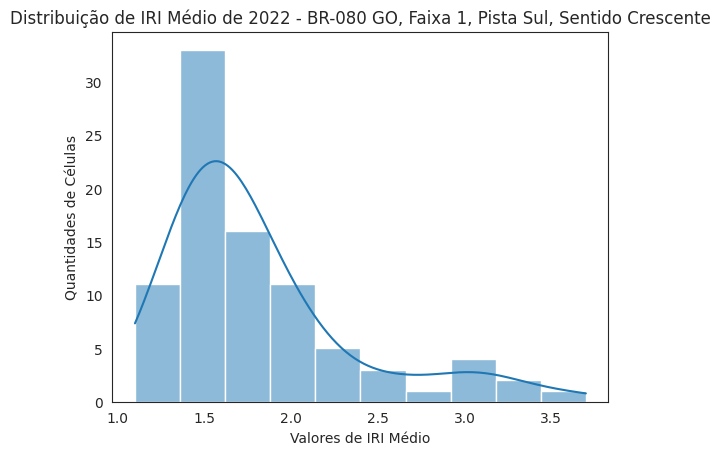

In [ ]:
caminho_arquivo = "Data/2022/ECA_IRI_BR-080 GO.xlsx"
busca_eixo_x="Início (km)"
busca_eixo_y="Média por segmento"
label_eixo_x="Valores de IRI Médio"
label_eixo_y="Quantidades de Células"

# Processar worksheet ESPECÍFICAS da planilha (por nomes ou índices)
print(f"\n=== ADSE - PROCESSANDO UMA WORKSHEET ESPECÍFICA DA PLANILHA {caminho_arquivo} ===")
df_especifica = carregar_excel(caminho_arquivo, sheet_name=0)
posicao_header = encontrar_header(df_especifica, busca_eixo_y, ocorrencia=2)
if posicao_header:
    linha_header, coluna_header = posicao_header
    valores_extraidos = extrair_valores_abaixo(df_especifica, linha_header, coluna_header)
    # Contabilizar os valores numéricos e vazios
    total, vazias, numericas = contar_valores(valores_extraidos)
    print(f"Total de células analisadas: {total} (100%)")
    print(f"Quantidade de células vazias: {vazias} ({(vazias * 100) / total:.2f}%)")
    print(f"Quantidade de células numéricas: {numericas} ({(numericas * 100) / total:.2f}%)")
    print("\nQuantidade de valores encontrados:", len(valores_extraidos))
else:
    print("O header não foi encontrado na planilha específica.")

ax = sns.histplot(valores_extraidos, bins=10, kde=True)
ax.set_xlabel(label_eixo_x)
ax.set_ylabel(label_eixo_y)
plt.title("Distribuição de IRI Médio de 2022 - BR-080 GO, Faixa 1, Pista Sul, Sentido Crescente")


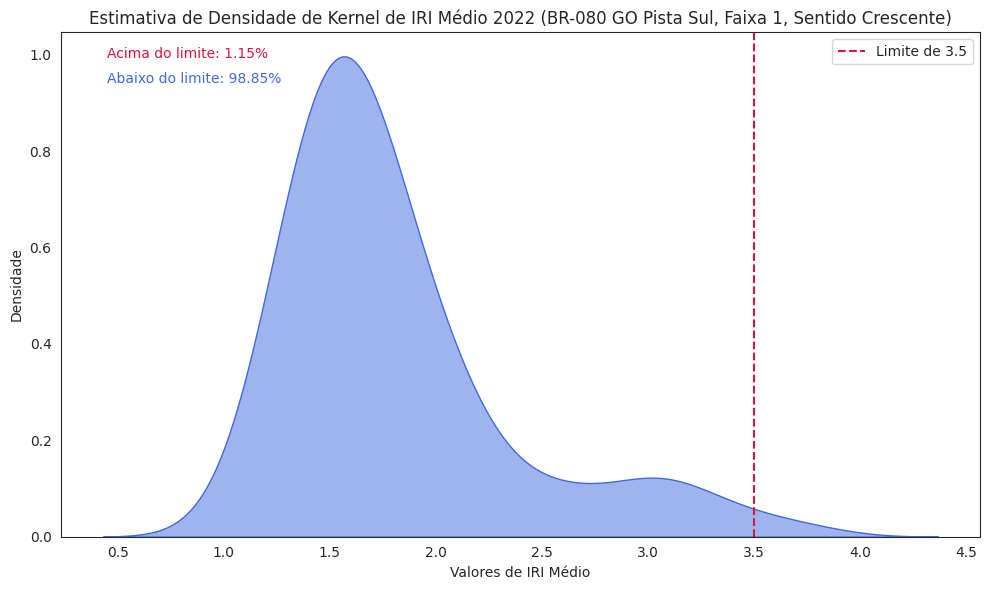


Resumo da Análise:
total_valores: 87
valores_acima_limite: 1
valores_abaixo_limite: 86
porcentagem_acima: 1.1494252873563218
porcentagem_abaixo: 98.85057471264368


In [ ]:
caminho_arquivo = "Data/2022/ECA_IRI_BR-080 GO.xlsx"
busca_eixo_y="Média por segmento"
label_titulo = "Estimativa de Densidade de Kernel de IRI Médio 2022 (BR-080 GO Pista Sul, Faixa 1, Sentido Crescente)"
label_eixo_x = "Valores de IRI Médio"
label_eixo_y = "Densidade"
limite = 3.5

def extrair_valores_abaixo(df, linha_header, coluna_header):
    """
    Extrai os valores abaixo do header localizado, na mesma coluna.
    Retorna uma Série do Pandas contendo os valores.
    """
    valores = df.iloc[linha_header + 1:, coluna_header].dropna()
    return pd.to_numeric(valores, errors='coerce').dropna()

def analisar_distribuicao_iri(caminho_arquivo, limite=3.5):
    """
    Analisa a distribuição de valores de IRI Médio, destacando valores acima do limite.

    Parâmetros:
        caminho_arquivo: caminho para o arquivo Excel
        limite: valor limite para análise (padrão 3.5)

    Retorna:
        Dicionário com informações da análise
    """
    # Carregar worksheet específica
    df_especifica = carregar_excel(caminho_arquivo, sheet_name=0)

    # Encontrar header de IRI Médio
    posicao_header = encontrar_header(df_especifica, busca_eixo_y, ocorrencia=2)

    if not posicao_header:
        raise ValueError(f"Não foi possível encontrar o header {busca_eixo_y}")

    linha_header, coluna_header = posicao_header

    # Extrair valores numéricos
    valores = extrair_valores_abaixo(df_especifica, linha_header, coluna_header)

    # Calcular porcentagens
    total_valores = len(valores)
    valores_acima_limite = valores[valores > limite]
    valores_abaixo_limite = valores[valores <= limite]

    porcentagem_acima = (len(valores_acima_limite) / total_valores) * 100
    porcentagem_abaixo = (len(valores_abaixo_limite) / total_valores) * 100

    # Criar plot KDE
    plt.figure(figsize=(10, 6))

    # Plot KDE
    sns.kdeplot(data=valores, fill=True, alpha=0.5, color='royalblue')

    # Linha vertical no limite
    plt.axvline(x=limite, color='crimson', linestyle='--', label=f'Limite de {limite}')

    plt.title(label_titulo)
    plt.xlabel(label_eixo_x)
    plt.ylabel(label_eixo_y)

    # Adicionar anotações de porcentagem
    plt.text(0.05, 0.95, f"Acima do limite: {porcentagem_acima:.2f}%",
             transform=plt.gca().transAxes, color='crimson')
    plt.text(0.05, 0.90, f"Abaixo do limite: {porcentagem_abaixo:.2f}%",
             transform=plt.gca().transAxes, color='royalblue')

    plt.legend()
    plt.tight_layout()
    plt.show()

    # Retornar resultados
    return {
        'total_valores': total_valores,
        'valores_acima_limite': len(valores_acima_limite),
        'valores_abaixo_limite': len(valores_abaixo_limite),
        'porcentagem_acima': porcentagem_acima,
        'porcentagem_abaixo': porcentagem_abaixo
    }

# Exemplo de uso
resultados = analisar_distribuicao_iri(caminho_arquivo, limite)
print("\nResumo da Análise:")
for chave, valor in resultados.items():
    print(f"{chave}: {valor}")

Os gráficos de histograma e distribuição acima demonstram quantitativamente e visualmente como os valores de IRI Médio encontram-se no ano de 2022 da BR-080 GO (Faixa 1, Pista Sul, Sentido Crescente), ou seja, em outras palavras: qual a quantidade de células para cada valor possivel de IRI Médio dos dados. Também mostram a Densidade em relação aos valores de IRI,  isto é, como está a distribuição do sistema e também traz o percentual acima e abaixo do limite (linha pontilhada traçada verticalmente) definido para o parametro.

É possivel observar-se um pico de valores de IRI Médio em aproximadamente 1.6, sendo este o pico máximo de quantidade de células, com aproximadamente 30 células de IRI Médio em 1.6. O que demonstra um valor ideal, já que estão abaixo dos dois limites estabelecidos pelo PER (de 2.7 e 3.5). As analises também evidenciaram 1.15% de valores acima do limite de 3.5.


=== PROCESSANDO UMA WORKSHEET ESPECÍFICA DA PLANILHA Data/2023/ECVA_IRI_BR-080 GO.xlsx ===
Total de células analisadas: 88 (100%)
Quantidade de células vazias: 0 (0.00%)
Quantidade de células numéricas: 88 (100.00%)

Quantidade de valores encontrados: 88


Text(0.5, 1.0, 'Distribuição de IRI Médio de 2023 - BR-080 GO, Faixa 1, Pista Norte, Sentido Crescente')

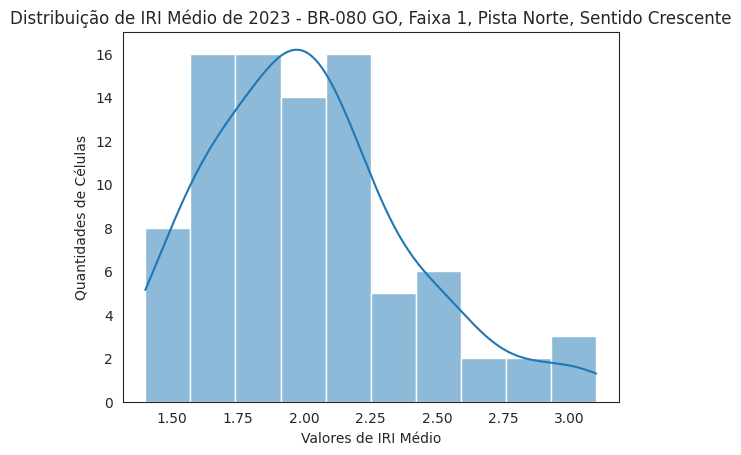

In [ ]:
caminho_arquivo = "Data/2023/ECVA_IRI_BR-080 GO.xlsx"
busca_eixo_x="Início (km)"
busca_eixo_y="Média por segmento"
label_titulo = "Distribuição de IRI Médio de 2023 - BR-080 GO, Faixa 1, Pista Norte, Sentido Crescente"
label_eixo_x="Valores de IRI Médio"
label_eixo_y="Quantidades de Células"

# Processar worksheet ESPECÍFICAS da planilha (por nomes ou índices)
print(f"\n=== PROCESSANDO UMA WORKSHEET ESPECÍFICA DA PLANILHA {caminho_arquivo} ===")
df_especifica = carregar_excel(caminho_arquivo, sheet_name=0)
posicao_header = encontrar_header(df_especifica, busca_eixo_y, ocorrencia=2)
if posicao_header:
    linha_header, coluna_header = posicao_header
    valores_extraidos = extrair_valores_abaixo(df_especifica, linha_header, coluna_header)
    # Contabilizar os valores numéricos e vazios
    total, vazias, numericas = contar_valores(valores_extraidos)
    print(f"Total de células analisadas: {total} (100%)")
    print(f"Quantidade de células vazias: {vazias} ({(vazias * 100) / total:.2f}%)")
    print(f"Quantidade de células numéricas: {numericas} ({(numericas * 100) / total:.2f}%)")
    print("\nQuantidade de valores encontrados:", len(valores_extraidos))
else:
    print("O header não foi encontrado na planilha específica.")

ax = sns.histplot(valores_extraidos, bins=10, kde=True)
ax.set_xlabel(label_eixo_x)
ax.set_ylabel(label_eixo_y)
plt.title(label_titulo)

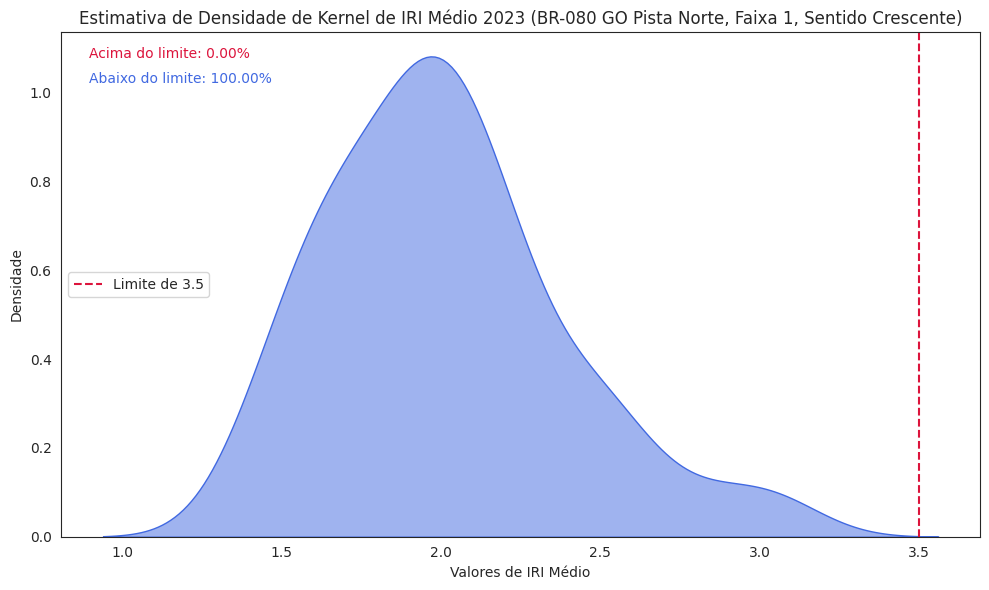


Resumo da Análise:
total_valores: 88
valores_acima_limite: 0
valores_abaixo_limite: 88
porcentagem_acima: 0.0
porcentagem_abaixo: 100.0


In [ ]:
caminho_arquivo = "Data/2023/ECVA_IRI_BR-080 GO.xlsx"
busca_eixo_y="Média por segmento"
label_titulo = "Estimativa de Densidade de Kernel de IRI Médio 2023 (BR-080 GO Pista Norte, Faixa 1, Sentido Crescente)"
label_eixo_x = "Valores de IRI Médio"
label_eixo_y = "Densidade"
limite = 3.5

def extrair_valores_abaixo(df, linha_header, coluna_header):
    """
    Extrai os valores abaixo do header localizado, na mesma coluna.
    Retorna uma Série do Pandas contendo os valores.
    """
    valores = df.iloc[linha_header + 1:, coluna_header].dropna()
    return pd.to_numeric(valores, errors='coerce').dropna()

def analisar_distribuicao_iri(caminho_arquivo, limite=3.5):
    """
    Analisa a distribuição de valores de IRI Médio, destacando valores acima do limite.

    Parâmetros:
        caminho_arquivo: caminho para o arquivo Excel
        limite: valor limite para análise (padrão 3.5)

    Retorna:
        Dicionário com informações da análise
    """
    # Carregar worksheet específica
    df_especifica = carregar_excel(caminho_arquivo, sheet_name=0)

    # Encontrar header de IRI Médio
    posicao_header = encontrar_header(df_especifica, busca_eixo_y, ocorrencia=2)

    if not posicao_header:
        raise ValueError("Não foi possível encontrar o header definido")

    linha_header, coluna_header = posicao_header

    # Extrair valores numéricos
    valores = extrair_valores_abaixo(df_especifica, linha_header, coluna_header)

    # Calcular porcentagens
    total_valores = len(valores)
    valores_acima_limite = valores[valores > limite]
    valores_abaixo_limite = valores[valores <= limite]

    porcentagem_acima = (len(valores_acima_limite) / total_valores) * 100
    porcentagem_abaixo = (len(valores_abaixo_limite) / total_valores) * 100

    # Criar plot KDE
    plt.figure(figsize=(10, 6))

    # Plot KDE
    sns.kdeplot(data=valores, fill=True, alpha=0.5, color='royalblue')

    # Linha vertical no limite
    plt.axvline(x=limite, color='crimson', linestyle='--', label=f'Limite de {limite}')

    plt.title(label_titulo)
    plt.xlabel(label_eixo_x)
    plt.ylabel(label_eixo_y)

    # Adicionar anotações de porcentagem
    plt.text(0.03, 0.95, f"Acima do limite: {porcentagem_acima:.2f}%",
             transform=plt.gca().transAxes, color='crimson')
    plt.text(0.03, 0.90, f"Abaixo do limite: {porcentagem_abaixo:.2f}%",
             transform=plt.gca().transAxes, color='royalblue')

    plt.legend()
    plt.tight_layout()
    plt.show()

    # Retornar resultados
    return {
        'total_valores': total_valores,
        'valores_acima_limite': len(valores_acima_limite),
        'valores_abaixo_limite': len(valores_abaixo_limite),
        'porcentagem_acima': porcentagem_acima,
        'porcentagem_abaixo': porcentagem_abaixo
    }

# Exemplo de uso
resultados = analisar_distribuicao_iri(caminho_arquivo, limite)
print("\nResumo da Análise:")
for chave, valor in resultados.items():
    print(f"{chave}: {valor}")

Os plots acima tratam-se de um histograma de quantidade por valores de IRI Médio e distribuição de densidade por valores de IRI Médio da mesma rodovia BR-080 GO (Faixa 1, Pista Norte, Sentido Crescente), contudo, do ano de 2023.

Foi possivel observar-se que houve uma diminuição de quantidade células mas aumento de valores de IRI Médio, ou seja, valores que antes, em 2022 o pico máximo se encontrava em aproximadamente 1.6 de valor de IRI, agora em 2023 encontra-se em aproximadamente valor 2.0. Os valores encontraram-se 100% abaixo do limite estabelecido do PER (de 3.5), sendo 0% o percentual excedente do limite máximo de 3.5, o que demonstra uma evolução significativa quando comparada os dados com os de 2022.

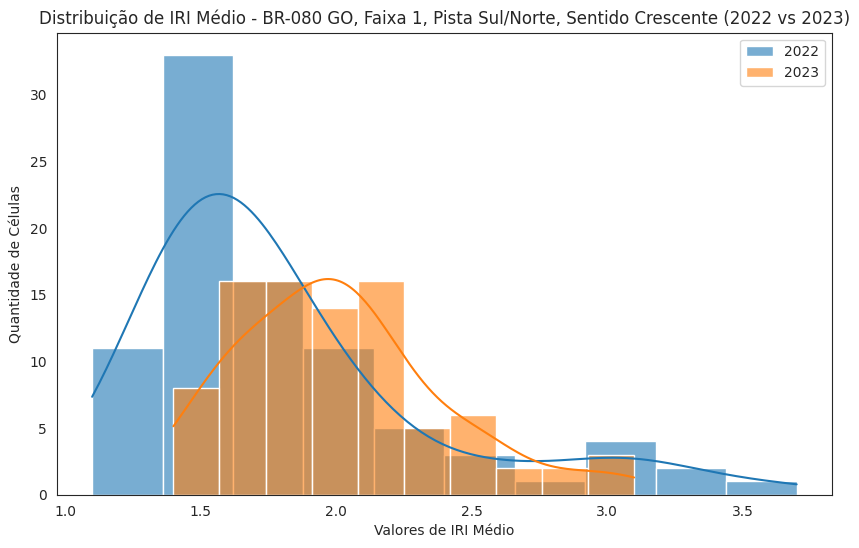

In [ ]:
caminho_arquivo_1 = "Data/2022/ECA_IRI_BR-080 GO.xlsx"
caminho_arquivo_2 = "Data/2023/ECVA_IRI_BR-080 GO.xlsx"
busca_eixo_y="Média por segmento"
label_titulo = "Distribuição de IRI Médio - BR-080 GO, Faixa 1, Pista Sul/Norte, Sentido Crescente (2022 vs 2023)"
label_eixo_x = "Valores de IRI Médio"
label_eixo_y = "Quantidade de Células"

# Processar dados de 2022
df_1 = carregar_excel(caminho_arquivo_1, sheet_name=0)
posicao_header_1 = encontrar_header(df_1, busca_eixo_y, ocorrencia=2)
valores_1 = extrair_valores_abaixo(df_1, *posicao_header_1)

# Processar dados de 2023
df_2 = carregar_excel(caminho_arquivo_2, sheet_name=0)
posicao_header_2 = encontrar_header(df_2, busca_eixo_y, ocorrencia=2)
valores_2 = extrair_valores_abaixo(df_2, *posicao_header_2)

# Criar figura e eixos
plt.figure(figsize=(10, 6))

# Plotar histograma com dados de 2022 e 2023
sns.histplot(data=valores_1, bins=10, kde=True, label='2022', alpha=0.6)
sns.histplot(data=valores_2, bins=10, kde=True, label='2023', alpha=0.6)

# Configurar labels e título
plt.xlabel(label_eixo_x)
plt.ylabel(label_eixo_y)
plt.title(label_titulo)
plt.legend()

# Mostrar o gráfico
plt.show()

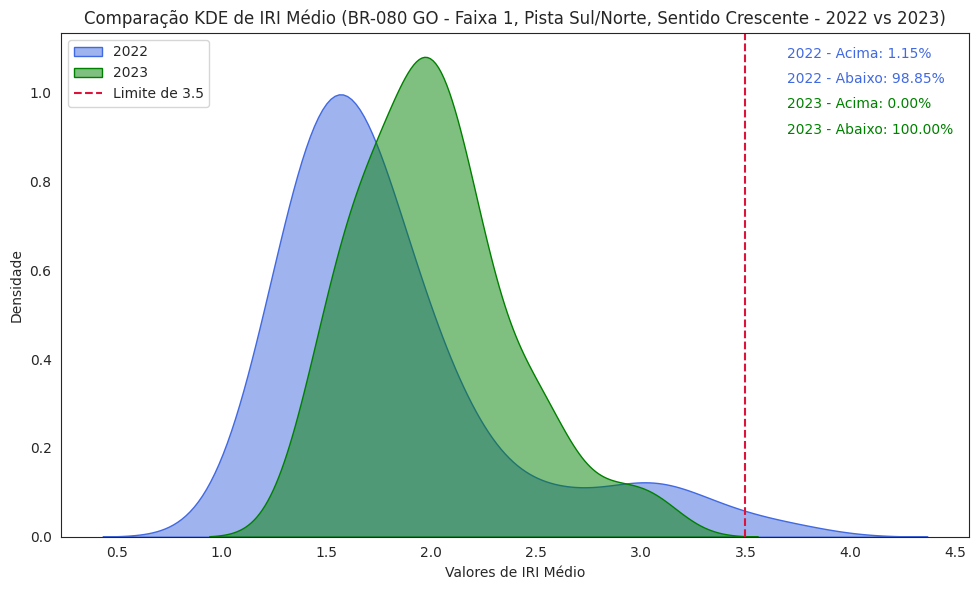


Resumo da Análise:
Arquivo 1:
  total_valores: 87
  porcentagem_acima: 1.1494252873563218
  porcentagem_abaixo: 98.85057471264368
Arquivo 2:
  total_valores: 88
  porcentagem_acima: 0.0
  porcentagem_abaixo: 100.0


In [ ]:
caminho_arquivo1 = "Data/2022/ECA_IRI_BR-080 GO.xlsx"
caminho_arquivo2 = "Data/2023/ECVA_IRI_BR-080 GO.xlsx"
busca_eixo_y="Média por segmento"
label_titulo = "Comparação KDE de IRI Médio (BR-080 GO - Faixa 1, Pista Sul/Norte, Sentido Crescente - 2022 vs 2023)"
label_eixo_x = "Valores de IRI Médio"
label_eixo_y = "Densidade"
limite = 3.5

def extrair_valores_abaixo(df, linha_header, coluna_header):
    valores = df.iloc[linha_header + 1:, coluna_header].dropna()
    return pd.to_numeric(valores, errors='coerce').dropna()

def analisar_comparacao_iri(caminho_arquivo1, caminho_arquivo2, limite=3.5):
    dados = {}

    for i, caminho_arquivo in enumerate([caminho_arquivo1, caminho_arquivo2], start=1):
        df = carregar_excel(caminho_arquivo, sheet_name=0)
        posicao_header = encontrar_header(df, busca_eixo_y, ocorrencia=2)

        if not posicao_header:
            raise ValueError(f"Não foi possível encontrar o header de IRI Médio no arquivo {i}")

        linha_header, coluna_header = posicao_header
        valores = extrair_valores_abaixo(df, linha_header, coluna_header)

        total_valores = len(valores)
        valores_acima = valores[valores > limite]
        valores_abaixo = valores[valores <= limite]

        dados[f'dataset_{i}'] = {
            'valores': valores,
            'total_valores': total_valores,
            'porcentagem_acima': (len(valores_acima) / total_valores) * 100,
            'porcentagem_abaixo': (len(valores_abaixo) / total_valores) * 100
        }

    # Criar gráfico KDE comparativo
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=dados['dataset_1']['valores'], fill=True, alpha=0.5, label="2022", color='royalblue')
    sns.kdeplot(data=dados['dataset_2']['valores'], fill=True, alpha=0.5, label="2023", color='green')

    # Linha vertical do limite
    plt.axvline(x=limite, color='crimson', linestyle='--', label=f'Limite de {limite}')

    plt.title(label_titulo)
    plt.xlabel(label_eixo_x)
    plt.ylabel(label_eixo_y)

    # Adicionar anotações de porcentagem
    plt.text(0.80, 0.95, f"2022 - Acima: {dados['dataset_1']['porcentagem_acima']:.2f}%",
             transform=plt.gca().transAxes, color='royalblue')
    plt.text(0.80, 0.90, f"2022 - Abaixo: {dados['dataset_1']['porcentagem_abaixo']:.2f}%",
             transform=plt.gca().transAxes, color='royalblue')
    plt.text(0.80, 0.85, f"2023 - Acima: {dados['dataset_2']['porcentagem_acima']:.2f}%",
             transform=plt.gca().transAxes, color='green')
    plt.text(0.80, 0.80, f"2023 - Abaixo: {dados['dataset_2']['porcentagem_abaixo']:.2f}%",
             transform=plt.gca().transAxes, color='green')

    plt.legend()
    plt.tight_layout()
    plt.show()

    return dados

resultados = analisar_comparacao_iri(caminho_arquivo1, caminho_arquivo2, limite)

print("\nResumo da Análise:")
for i, dataset in enumerate(resultados.values(), start=1):
    print(f"Arquivo {i}:")
    for chave, valor in dataset.items():
        if chave != 'valores':
            print(f"  {chave}: {valor}")

Os histogramas e distribuições da BR-080 (Faixa 1, Pista Sul/Norte, Sentido Crescente), quando empilhados para uma comparação temporal de 2022 vs 2023, realçam uma visualização clara de suas diferenças descritas anteriormente e demonstram uma evolução positiva de 2022 para 2023 em relação a seus percentuais excedentes de limites — de 1.15% para 0.00% acima do limite superior de 3.5 do PER, no entanto, o pico máximo de densidade de 2023 se deslocou para valores mais proximos do limite.

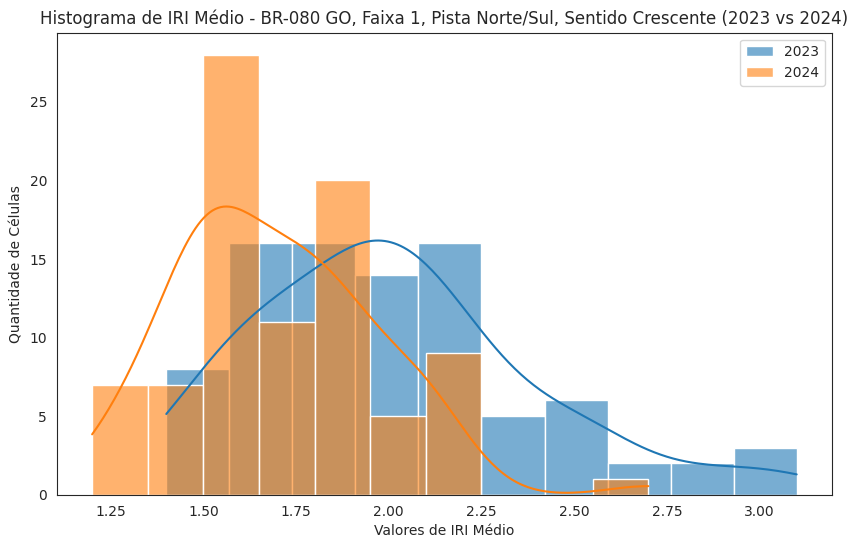

In [ ]:
caminho_arquivo_1 = "Data/2023/ECVA_IRI_BR-080 GO.xlsx"
caminho_arquivo_2 = "Data/2024/ECVA_IRI_BR-080 GO.xlsx"
busca_eixo_y="Média por segmento"
label_titulo = "Histograma de IRI Médio - BR-080 GO, Faixa 1, Pista Norte/Sul, Sentido Crescente (2023 vs 2024)"
label_eixo_x = "Valores de IRI Médio"
label_eixo_y = "Quantidade de Células"

# Processar dados de 2023
df_1 = carregar_excel(caminho_arquivo_1, sheet_name=0)
posicao_header_1 = encontrar_header(df_1, busca_eixo_y, ocorrencia=2)
valores_1 = extrair_valores_abaixo(df_1, *posicao_header_1)

# Processar dados de 2024
df_2 = carregar_excel(caminho_arquivo_2, sheet_name=0)
posicao_header_2 = encontrar_header(df_2, busca_eixo_y, ocorrencia=2)
valores_2 = extrair_valores_abaixo(df_2, *posicao_header_2)

# Criar figura e eixos
plt.figure(figsize=(10, 6))

# Plotar histograma com dados de 2023 e 2024
sns.histplot(data=valores_1, bins=10, kde=True, label='2023', alpha=0.6)
sns.histplot(data=valores_2, bins=10, kde=True, label='2024', alpha=0.6)

# Configurar labels e título
plt.xlabel(label_eixo_x)
plt.ylabel(label_eixo_y)
plt.title(label_titulo)
plt.legend()

# Mostrar o gráfico
plt.show()

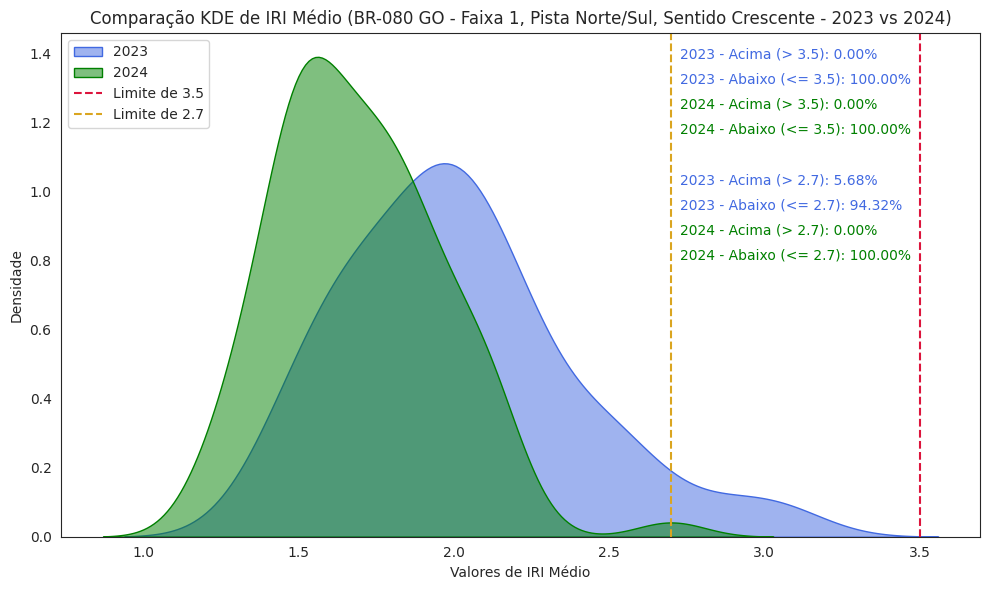


Resumo da Análise:
Arquivo 1:
  total_valores: 88
  porcentagem_acima_lim_1: 0.0
  porcentagem_abaixo_lim_1: 100.0
  porcentagem_acima_lim_2: 5.681818181818182
  porcentagem_abaixo_lim_2: 94.31818181818183
Arquivo 2:
  total_valores: 88
  porcentagem_acima_lim_1: 0.0
  porcentagem_abaixo_lim_1: 100.0
  porcentagem_acima_lim_2: 0.0
  porcentagem_abaixo_lim_2: 100.0


In [ ]:
caminho_arquivo1 = "Data/2023/ECVA_IRI_BR-080 GO.xlsx"
caminho_arquivo2 = "Data/2024/ECVA_IRI_BR-080 GO.xlsx"
busca_eixo_y="Média por segmento"

label_titulo = "Comparação KDE de IRI Médio (BR-080 GO - Faixa 1, Pista Norte/Sul, Sentido Crescente - 2023 vs 2024)"
label_eixo_x = "Valores de IRI Médio"
label_eixo_y = "Densidade"

limite1 = 3.5
limite2 = 2.7

def extrair_valores_abaixo(df, linha_header, coluna_header):
    valores = df.iloc[linha_header + 1:, coluna_header].dropna()
    return pd.to_numeric(valores, errors='coerce').dropna()

def analisar_comparacao_iri(caminho_arquivo1, caminho_arquivo2, limite1=3.5, limite2=2.7):
    dados = {}

    for i, caminho_arquivo in enumerate([caminho_arquivo1, caminho_arquivo2], start=1):
        df = carregar_excel(caminho_arquivo, sheet_name=0)
        posicao_header = encontrar_header(df, busca_eixo_y, ocorrencia=2)

        if not posicao_header:
            raise ValueError(f"Não foi possível encontrar o header de IRI Médio no arquivo {i}")

        linha_header, coluna_header = posicao_header
        valores = extrair_valores_abaixo(df, linha_header, coluna_header)

        total_valores = len(valores)
        valores_acima_lim_1 = valores[valores > limite1]
        valores_abaixo_lim_1 = valores[valores <= limite1]
        valores_acima_lim_2 = valores[valores > limite2]
        valores_abaixo_lim_2 = valores[valores <= limite2]

        dados[f'dataset_{i}'] = {
            'valores': valores,
            'total_valores': total_valores,
            'porcentagem_acima_lim_1': (len(valores_acima_lim_1) / total_valores) * 100,
            'porcentagem_abaixo_lim_1': (len(valores_abaixo_lim_1) / total_valores) * 100,
            'porcentagem_acima_lim_2': (len(valores_acima_lim_2) / total_valores) * 100,
            'porcentagem_abaixo_lim_2': (len(valores_abaixo_lim_2) / total_valores) * 100
        }

    # Criar gráfico KDE comparativo
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=dados['dataset_1']['valores'], fill=True, alpha=0.5, label="2023", color='royalblue')
    sns.kdeplot(data=dados['dataset_2']['valores'], fill=True, alpha=0.5, label="2024", color='green')

    # Linha vertical do limite 3.5
    plt.axvline(x=limite1, color='crimson', linestyle='--', label=f'Limite de {limite1}')
    # Linha vertical do limite 2.7
    plt.axvline(x=limite2, color='goldenrod', linestyle='--', label=f'Limite de {limite2}')

    plt.title(label_titulo)
    plt.xlabel(label_eixo_x)
    plt.ylabel(label_eixo_y)

    # Adicionar anotações de porcentagem limite 1
    plt.text(0.674, 0.95, f"2023 - Acima (> {limite1}): {dados['dataset_1']['porcentagem_acima_lim_1']:.2f}%",
             transform=plt.gca().transAxes, color='royalblue')
    plt.text(0.674, 0.90, f"2023 - Abaixo (<= {limite1}): {dados['dataset_1']['porcentagem_abaixo_lim_1']:.2f}%",
             transform=plt.gca().transAxes, color='royalblue')
    plt.text(0.674, 0.85, f"2024 - Acima (> {limite1}): {dados['dataset_2']['porcentagem_acima_lim_1']:.2f}%",
             transform=plt.gca().transAxes, color='green')
    plt.text(0.674, 0.80, f"2024 - Abaixo (<= {limite1}): {dados['dataset_2']['porcentagem_abaixo_lim_1']:.2f}%",
             transform=plt.gca().transAxes, color='green')

    # Adicionar anotações de porcentagem limite 2
    plt.text(0.674, 0.70, f"2023 - Acima (> {limite2}): {dados['dataset_1']['porcentagem_acima_lim_2']:.2f}%",
             transform=plt.gca().transAxes, color='royalblue')
    plt.text(0.674, 0.65, f"2023 - Abaixo (<= {limite2}): {dados['dataset_1']['porcentagem_abaixo_lim_2']:.2f}%",
             transform=plt.gca().transAxes, color='royalblue')
    plt.text(0.674, 0.60, f"2024 - Acima (> {limite2}): {dados['dataset_2']['porcentagem_acima_lim_2']:.2f}%",
             transform=plt.gca().transAxes, color='green')
    plt.text(0.674, 0.55, f"2024 - Abaixo (<= {limite2}): {dados['dataset_2']['porcentagem_abaixo_lim_2']:.2f}%",
             transform=plt.gca().transAxes, color='green')

    plt.legend()
    plt.tight_layout()
    plt.show()

    return dados

resultados = analisar_comparacao_iri(caminho_arquivo1, caminho_arquivo2, limite1, limite2)

print("\nResumo da Análise:")
for i, dataset in enumerate(resultados.values(), start=1):
    print(f"Arquivo {i}:")
    for chave, valor in dataset.items():
        if chave != 'valores':
            print(f"  {chave}: {valor}")

Os histogramas e distribuições da BR-080 (Faixa 1, Pista Norte/Sul, Sentido Crescente) em uma comparação temporal de 2023 vs 2024 demonstram uma evolução positiva em relação aos limites de 3.5 e 2.7 (estabelecido no PER), mesmo que ambos possuam 0% de percentual excedentes porque ao observar o pico máximo da densidade, houve um deslocamento onde os valores de 2024 se distanciaram ainda mais dos limites, portanto, tornando-se mais proximos de valores ideais e mais distantes dos limites estabelecidos do PER. A crescente na altura da densidade em 2024 também representa uma evolução positiva, significando que a carga de dados está concentrada em valores mais abaixos e mais distantes dos limites. É possivel também visualizar todas as diferenças temporais descritas anteriormente ao adicionar 2022 na comparação temporal de 2023 vs 2024, ou seja, os tres anos, evidenciando a evolução, como a seguir:

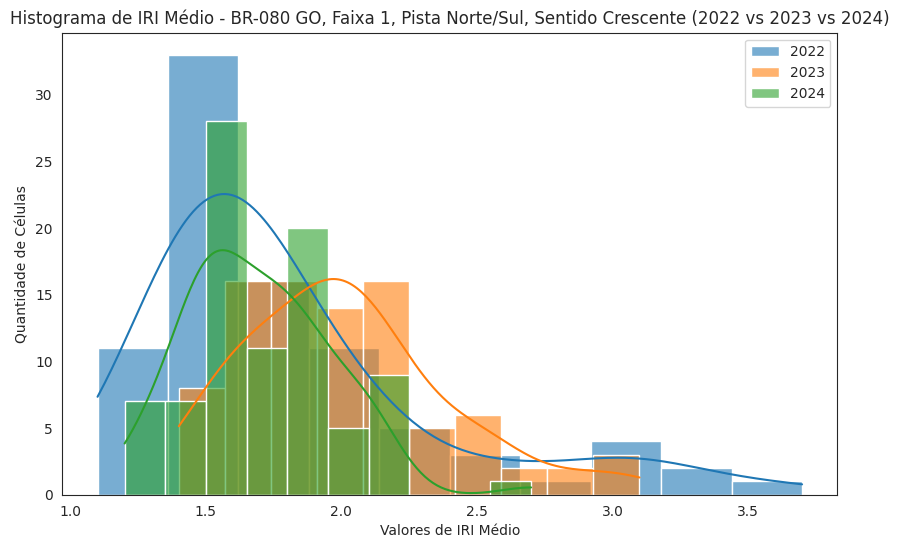

In [ ]:
caminho_arquivo_0 = "Data/2022/ECA_IRI_BR-080 GO.xlsx"
caminho_arquivo_1 = "Data/2023/ECVA_IRI_BR-080 GO.xlsx"
caminho_arquivo_2 = "Data/2024/ECVA_IRI_BR-080 GO.xlsx"
busca_eixo_y="Média por segmento"

label_titulo = "Histograma de IRI Médio - BR-080 GO, Faixa 1, Pista Norte/Sul, Sentido Crescente (2022 vs 2023 vs 2024)"
label_eixo_x = "Valores de IRI Médio"
label_eixo_y = "Quantidade de Células"

# Processar dados de 2022
df_0 = carregar_excel(caminho_arquivo_0, sheet_name=0)
posicao_header_0 = encontrar_header(df_0, busca_eixo_y, ocorrencia=2)
valores_0 = extrair_valores_abaixo(df_0, *posicao_header_0)

# Processar dados de 2023
df_1 = carregar_excel(caminho_arquivo_1, sheet_name=0)
posicao_header_1 = encontrar_header(df_1, busca_eixo_y, ocorrencia=2)
valores_1 = extrair_valores_abaixo(df_1, *posicao_header_1)

# Processar dados de 2024
df_2 = carregar_excel(caminho_arquivo_2, sheet_name=0)
posicao_header_2 = encontrar_header(df_2, busca_eixo_y, ocorrencia=2)
valores_2 = extrair_valores_abaixo(df_2, *posicao_header_2)

# Criar figura e eixos
plt.figure(figsize=(10, 6))

# Plotar histograma com dados de 2023 e 2024
sns.histplot(data=valores_0, bins=10, kde=True, label='2022', alpha=0.6)
sns.histplot(data=valores_1, bins=10, kde=True, label='2023', alpha=0.6)
sns.histplot(data=valores_2, bins=10, kde=True, label='2024', alpha=0.6)

# Configurar labels e título
plt.xlabel(label_eixo_x)
plt.ylabel(label_eixo_y)
plt.title(label_titulo)
plt.legend()

# Mostrar o gráfico
plt.show()

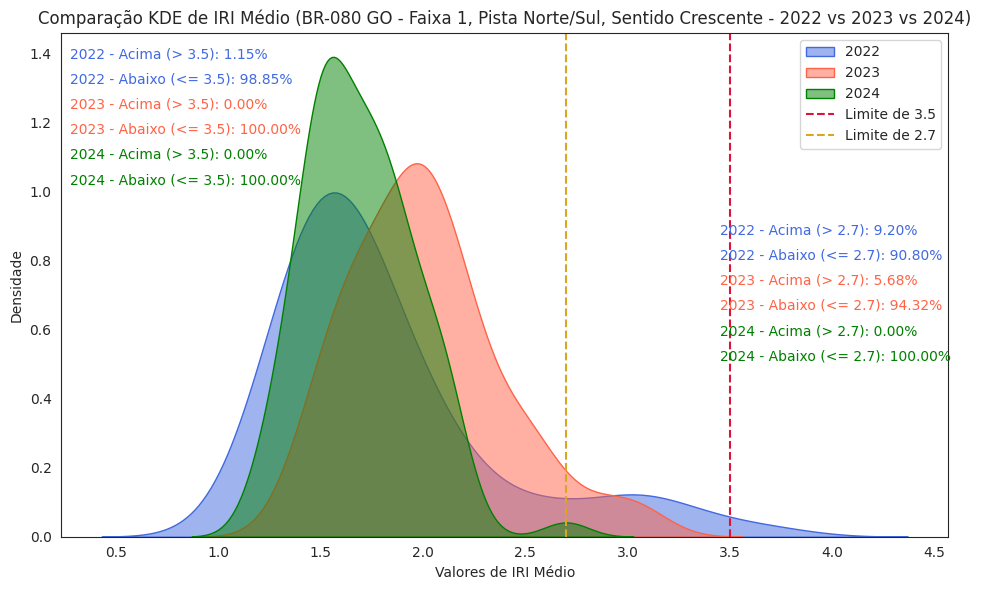


Resumo da Análise:
Arquivo 1:
  total_valores: 87
  porcentagem_acima_lim_1: 1.1494252873563218
  porcentagem_abaixo_lim_1: 98.85057471264368
  porcentagem_acima_lim_2: 9.195402298850574
  porcentagem_abaixo_lim_2: 90.80459770114942
Arquivo 2:
  total_valores: 88
  porcentagem_acima_lim_1: 0.0
  porcentagem_abaixo_lim_1: 100.0
  porcentagem_acima_lim_2: 5.681818181818182
  porcentagem_abaixo_lim_2: 94.31818181818183
Arquivo 3:
  total_valores: 88
  porcentagem_acima_lim_1: 0.0
  porcentagem_abaixo_lim_1: 100.0
  porcentagem_acima_lim_2: 0.0
  porcentagem_abaixo_lim_2: 100.0


In [ ]:
caminho_arquivo0 = "Data/2022/ECA_IRI_BR-080 GO.xlsx"
caminho_arquivo1 = "Data/2023/ECVA_IRI_BR-080 GO.xlsx"
caminho_arquivo2 = "Data/2024/ECVA_IRI_BR-080 GO.xlsx"
busca_eixo_y="Média por segmento"

label_titulo = "Comparação KDE de IRI Médio (BR-080 GO - Faixa 1, Pista Norte/Sul, Sentido Crescente - 2022 vs 2023 vs 2024)"
label_eixo_x = "Valores de IRI Médio"
label_eixo_y = "Densidade"

limite1 = 3.5
limite2 = 2.7

def extrair_valores_abaixo(df, linha_header, coluna_header):
    valores = df.iloc[linha_header + 1:, coluna_header].dropna()
    return pd.to_numeric(valores, errors='coerce').dropna()

def analisar_comparacao_iri(caminho_arquivo0, caminho_arquivo1, caminho_arquivo2, limite1=3.5, limite2=2.7):
    dados = {}

    for i, caminho_arquivo in enumerate([caminho_arquivo0, caminho_arquivo1, caminho_arquivo2], start=1):
        df = carregar_excel(caminho_arquivo, sheet_name=0)
        posicao_header = encontrar_header(df, busca_eixo_y, ocorrencia=2)

        if not posicao_header:
            raise ValueError(f"Não foi possível encontrar o header de IRI Médio no arquivo {i}")

        linha_header, coluna_header = posicao_header
        valores = extrair_valores_abaixo(df, linha_header, coluna_header)

        total_valores = len(valores)
        valores_acima_lim_1 = valores[valores > limite1]
        valores_abaixo_lim_1 = valores[valores <= limite1]
        valores_acima_lim_2 = valores[valores > limite2]
        valores_abaixo_lim_2 = valores[valores <= limite2]

        dados[f'dataset_{i}'] = {
            'valores': valores,
            'total_valores': total_valores,
            'porcentagem_acima_lim_1': (len(valores_acima_lim_1) / total_valores) * 100,
            'porcentagem_abaixo_lim_1': (len(valores_abaixo_lim_1) / total_valores) * 100,
            'porcentagem_acima_lim_2': (len(valores_acima_lim_2) / total_valores) * 100,
            'porcentagem_abaixo_lim_2': (len(valores_abaixo_lim_2) / total_valores) * 100
        }

    # Criar gráfico KDE comparativo
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=dados['dataset_1']['valores'], fill=True, alpha=0.5, label="2022", color='royalblue')
    sns.kdeplot(data=dados['dataset_2']['valores'], fill=True, alpha=0.5, label="2023", color='tomato')
    sns.kdeplot(data=dados['dataset_3']['valores'], fill=True, alpha=0.5, label="2024", color='green')

    # Linha vertical do limite
    plt.axvline(x=limite1, color='crimson', linestyle='--', label=f'Limite de {limite1}')
    # Linha vertical do limite 2.7
    plt.axvline(x=limite2, color='goldenrod', linestyle='--', label=f'Limite de {limite2}')

    plt.title(label_titulo)
    plt.xlabel(label_eixo_x)
    plt.ylabel(label_eixo_y)

    # Adicionar anotações de porcentagem limite 2
    plt.text(0.010, 0.95, f"2022 - Acima (> {limite1}): {dados['dataset_1']['porcentagem_acima_lim_1']:.2f}%",
             transform=plt.gca().transAxes, color='royalblue')
    plt.text(0.010, 0.90, f"2022 - Abaixo (<= {limite1}): {dados['dataset_1']['porcentagem_abaixo_lim_1']:.2f}%",
             transform=plt.gca().transAxes, color='royalblue')
    plt.text(0.010, 0.85, f"2023 - Acima (> {limite1}): {dados['dataset_2']['porcentagem_acima_lim_1']:.2f}%",
             transform=plt.gca().transAxes, color='tomato')
    plt.text(0.010, 0.80, f"2023 - Abaixo (<= {limite1}): {dados['dataset_2']['porcentagem_abaixo_lim_1']:.2f}%",
             transform=plt.gca().transAxes, color='tomato')
    plt.text(0.010, 0.75, f"2024 - Acima (> {limite1}): {dados['dataset_3']['porcentagem_acima_lim_1']:.2f}%",
             transform=plt.gca().transAxes, color='green')
    plt.text(0.010, 0.70, f"2024 - Abaixo (<= {limite1}): {dados['dataset_3']['porcentagem_abaixo_lim_1']:.2f}%",
             transform=plt.gca().transAxes, color='green')

    # Adicionar anotações de porcentagem limite 2
    plt.text(0.743, 0.60, f"2022 - Acima (> {limite2}): {dados['dataset_1']['porcentagem_acima_lim_2']:.2f}%",
             transform=plt.gca().transAxes, color='royalblue')
    plt.text(0.743, 0.55, f"2022 - Abaixo (<= {limite2}): {dados['dataset_1']['porcentagem_abaixo_lim_2']:.2f}%",
             transform=plt.gca().transAxes, color='royalblue')
    plt.text(0.743, 0.50, f"2023 - Acima (> {limite2}): {dados['dataset_2']['porcentagem_acima_lim_2']:.2f}%",
             transform=plt.gca().transAxes, color='tomato')
    plt.text(0.743, 0.45, f"2023 - Abaixo (<= {limite2}): {dados['dataset_2']['porcentagem_abaixo_lim_2']:.2f}%",
             transform=plt.gca().transAxes, color='tomato')
    plt.text(0.743, 0.40, f"2024 - Acima (> {limite2}): {dados['dataset_3']['porcentagem_acima_lim_2']:.2f}%",
             transform=plt.gca().transAxes, color='green')
    plt.text(0.743, 0.35, f"2024 - Abaixo (<= {limite2}): {dados['dataset_3']['porcentagem_abaixo_lim_2']:.2f}%",
             transform=plt.gca().transAxes, color='green')

    plt.legend()
    plt.tight_layout()
    plt.show()

    return dados

resultados = analisar_comparacao_iri(caminho_arquivo0, caminho_arquivo1, caminho_arquivo2, limite1, limite2)

print("\nResumo da Análise:")
for i, dataset in enumerate(resultados.values(), start=1):
    print(f"Arquivo {i}:")
    for chave, valor in dataset.items():
        if chave != 'valores':
            print(f"  {chave}: {valor}")

Para analisar temporalmente os 3 anos da rodovia, é possivel utilizar a ferramenta acima que plota um histograma de Quantidade de células por Valores de IRI Médio e Densidade por Valores de IRI Médio, com as 3 curvas dos respectivos anos simultaneamente.

É possivel concluir que a rodovia BR-080 GO, quando visualizada temporalmente (dados de 2022, 2023 e 2024) como nos gráficos de Histograma e Distribuição acima, mostram-se com uma evolução positiva no geral, nos tres anos observados, evidenciando-se um distanciamento dos limites de IRI estabelecidos no PER e a densidade se tornando em 2024 valores ideais.

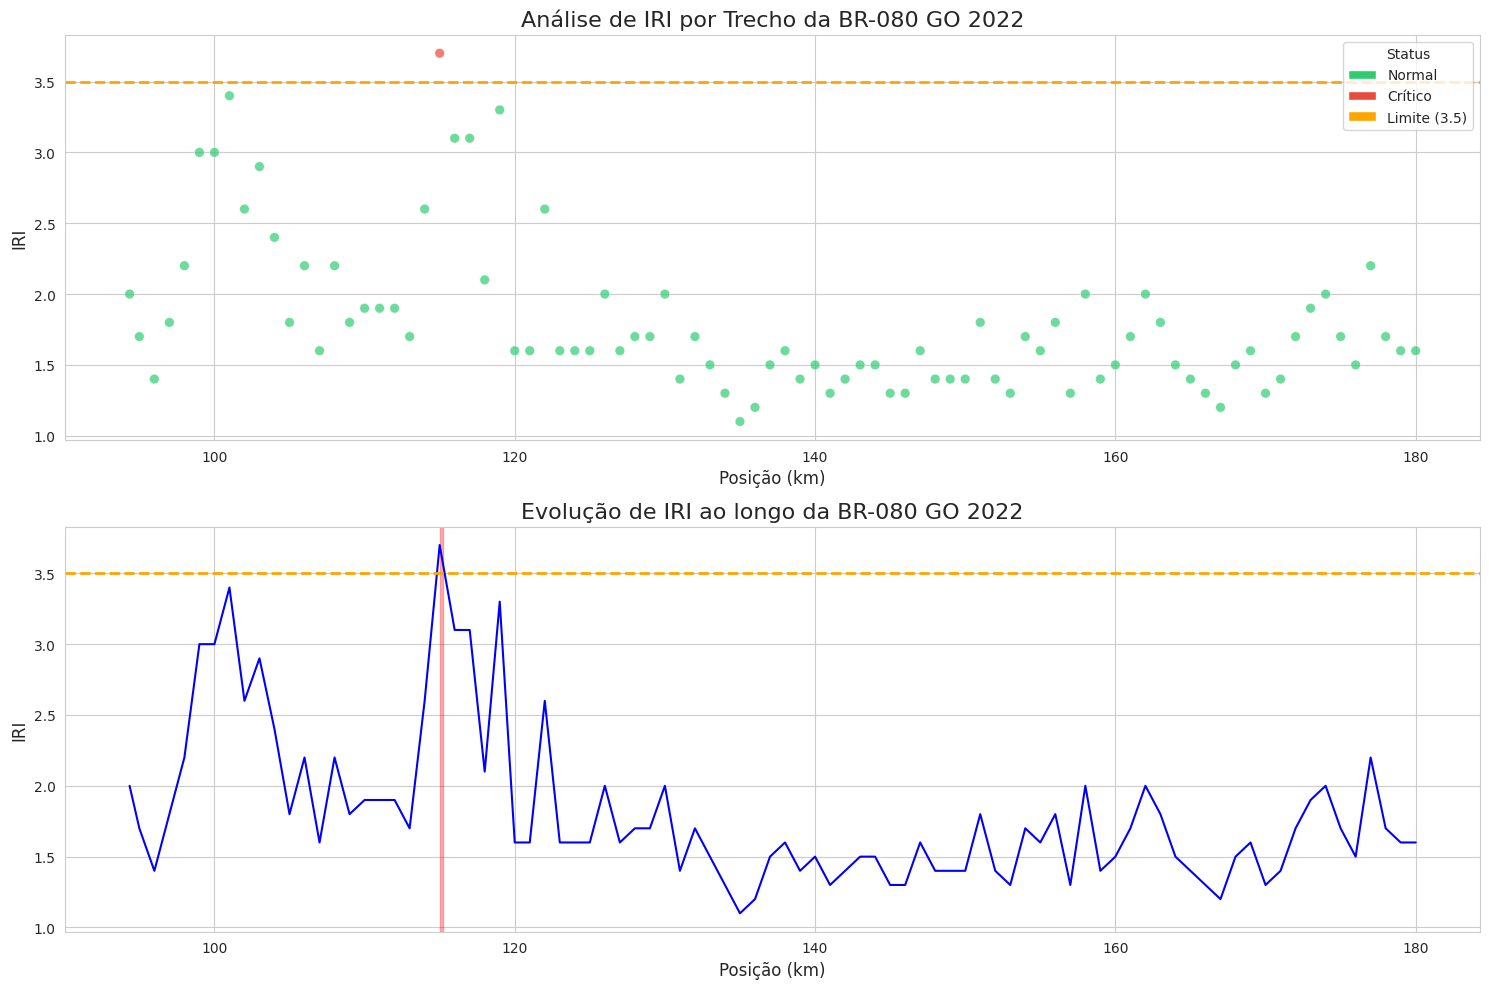

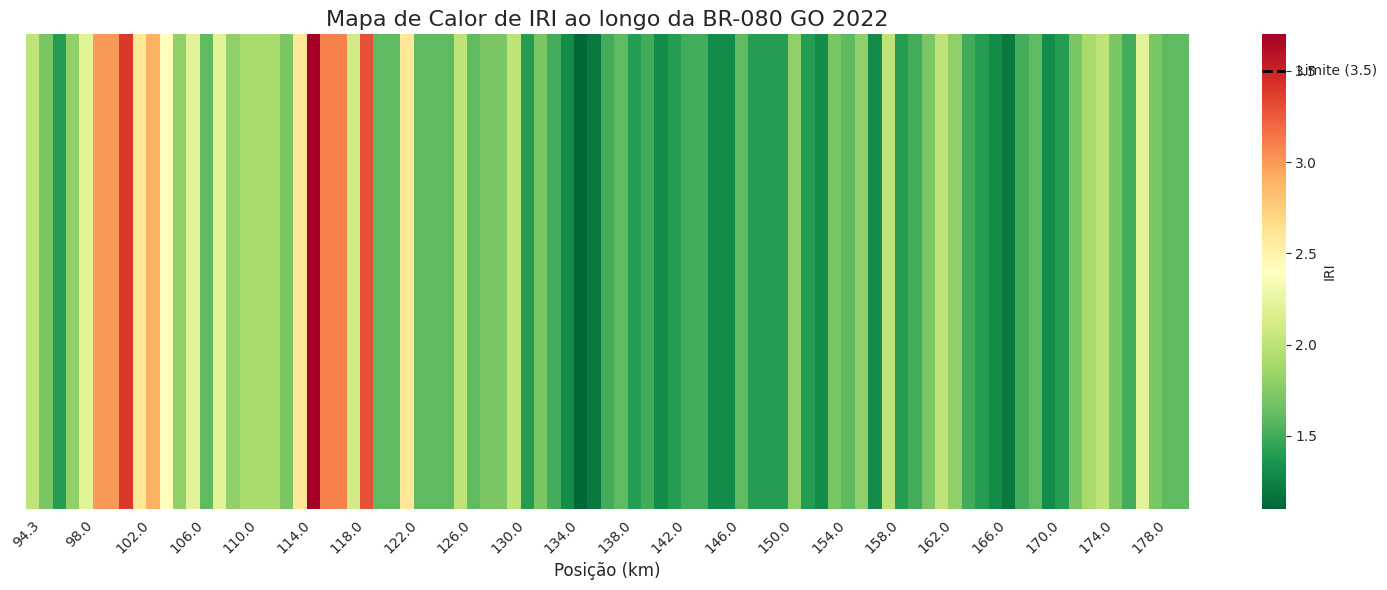

=================== RELATÓRIO DE ANÁLISE ===================
Parâmetro: IRI
Limite: 3.5
Data da análise: 16/06/2025 20:41

=== RESUMO ===
Total de trechos analisados: 87
Trechos críticos encontrados: 1 (1.1%)
Número de segmentos críticos contínuos: 1

=== SEGMENTOS CRÍTICOS ===
Segmento 1: km 115.0 a 115.0 (0.0 km) - IRI médio: 3.70, máximo: 3.70

=== ESTATÍSTICAS DOS SEGMENTOS CRÍTICOS ===
Extensão total crítica: 0.0 km
Média do IRI nos trechos críticos: 3.70
Valor máximo registrado: 3.70 (em km 115.0)



In [ ]:
arquivo = "Data/2022/ECA_IRI_BR-080 GO.xlsx"
parametro = "Média por segmento"
km = "Início (km)"
label_rodovia = "BR-080 GO 2022"
limite_iri = 3.5
ocorrencia_iri = 2  # Segunda ocorrência especificamente para o IRI (porque há duas colunas com o mesmo nome "Média por segmento" na planilha

def extrair_valores_abaixo(df, linha_header, coluna_header, qtd_linhas=None):
    """
    Extrai os valores abaixo do header localizado, na mesma coluna.

    Parâmetros:
        df: DataFrame fonte
        linha_header: linha onde está o header
        coluna_header: coluna onde está o header
        qtd_linhas: quantidade de linhas a extrair (None para extrair todas)

    Retorna:
        Uma Série do Pandas contendo os valores.
    """
    if qtd_linhas:
        return df.iloc[linha_header + 1:linha_header + 1 + qtd_linhas, coluna_header]
    return df.iloc[linha_header + 1:, coluna_header]

def analisar_trechos_criticos(caminho_arquivo, parametro_header, km_header, limite,
                              ocorrencia_parametro=1, ocorrencia_km=1, sheet_name=0):
    """
    Analisa os trechos críticos de uma rodovia com base em um parâmetro específico.

    Parâmetros:
        caminho_arquivo: caminho para o arquivo Excel
        parametro_header: nome do cabeçalho do parâmetro a ser analisado
        km_header: nome do cabeçalho da posição quilométrica
        limite: valor limite do parâmetro para considerar trecho crítico
        ocorrencia_parametro: ocorrência do cabeçalho do parâmetro a ser considerada
        ocorrencia_km: ocorrência do cabeçalho da posição quilométrica a ser considerada
        sheet_name: nome ou índice da planilha a ser analisada

    Retorna:
        DataFrame com os trechos críticos identificados
    """
    # Carregar a planilha
    df = carregar_excel(caminho_arquivo, sheet_name)

    # Encontrar os cabeçalhos
    pos_parametro = encontrar_header(df, parametro_header, ocorrencia_parametro)
    pos_km = encontrar_header(df, km_header, ocorrencia_km)

    if not pos_parametro or not pos_km:
        raise ValueError(f"Não foi possível encontrar os cabeçalhos: {parametro_header} (ocorrência {ocorrencia_parametro}) "
                         f"ou {km_header} (ocorrência {ocorrencia_km})")

    # Extrair os valores
    valores_parametro = extrair_valores_abaixo(df, pos_parametro[0], pos_parametro[1])
    valores_km = extrair_valores_abaixo(df, pos_km[0], pos_km[1])

    # Determinar o tamanho máximo comum (importante caso haja diferenças nos tamanhos das séries)
    tamanho_comum = min(len(valores_parametro), len(valores_km))

    # Criar um DataFrame com os valores
    resultado = pd.DataFrame({
        'Km': valores_km.iloc[:tamanho_comum].reset_index(drop=True),
        'Parametro': valores_parametro.iloc[:tamanho_comum].reset_index(drop=True)
    })

    # Remover linhas com valores NaN ou vazios
    resultado = resultado.dropna()

    # Converter para numérico (caso tenha valores textuais)
    resultado['Parametro'] = pd.to_numeric(resultado['Parametro'], errors='coerce')
    resultado['Km'] = pd.to_numeric(resultado['Km'], errors='coerce')

    # Identificar trechos críticos
    resultado['Critico'] = resultado['Parametro'] > limite

    return resultado

def identificar_segmentos_criticos(df_trechos):
    """
    Identifica segmentos contínuos de trechos críticos.

    Parâmetros:
        df_trechos: DataFrame com os trechos analisados

    Retorna:
        DataFrame com os segmentos críticos identificados
    """
    # Criar uma cópia para não modificar o original
    df = df_trechos.copy()

    # Identificar mudanças no estado crítico/não-crítico
    df['grupo'] = (df['Critico'] != df['Critico'].shift()).cumsum()

    # Filtrar apenas os grupos críticos
    grupos_criticos = df[df['Critico']]

    # Agrupar por grupo e obter informações de início, fim e estatísticas
    segmentos = []
    for grupo, dados in grupos_criticos.groupby('grupo'):
        segmentos.append({
            'Inicio_Km': dados['Km'].min(),
            'Fim_Km': dados['Km'].max(),
            'Extensao': dados['Km'].max() - dados['Km'].min(),
            'Media_Parametro': dados['Parametro'].mean(),
            'Max_Parametro': dados['Parametro'].max(),
            'N_Pontos': len(dados)
        })

    # Criar DataFrame de segmentos
    if segmentos:
        df_segmentos = pd.DataFrame(segmentos)
        return df_segmentos.sort_values('Inicio_Km')
    else:
        return pd.DataFrame(columns=['Inicio_Km', 'Fim_Km', 'Extensao', 'Media_Parametro', 'Max_Parametro', 'N_Pontos'])

def visualizar_trechos_criticos(df_trechos, nome_parametro, limite, caminho_arquivo=None):
    """
    Gera visualizações dos trechos críticos.

    Parâmetros:
        df_trechos: DataFrame com os trechos analisados
        nome_parametro: nome do parâmetro para exibição nos gráficos
        limite: valor limite do parâmetro
        caminho_arquivo: caminho para salvar as visualizações (opcional)
    """
    # Configurar estilo do gráfico
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 10))

    # Configurar cores
    cores = ['#2ecc71', '#e74c3c']  # Verde para normal, vermelho para crítico

    # Plotar gráfico de dispersão
    plt.subplot(2, 1, 1)
    scatter = sns.scatterplot(x='Km', y='Parametro', hue='Critico', data=df_trechos,
                             palette=cores, s=50, alpha=0.7)

    # Adicionar linha do limite
    plt.axhline(y=limite, color='orange', linestyle='--', linewidth=2, label=f'Limite ({limite})')

    # Configurar título e legendas
    plt.title(f'Análise de {nome_parametro} por Trecho da {label_rodovia}', fontsize=16)
    plt.xlabel('Posição (km)', fontsize=12)
    plt.ylabel(nome_parametro, fontsize=12)

    # Configurar legenda personalizada
    handles = [
        Patch(facecolor=cores[0], label='Normal'),
        Patch(facecolor=cores[1], label='Crítico'),
        Patch(facecolor='orange', label=f'Limite ({limite})')
    ]
    plt.legend(handles=handles, loc='upper right', title='Status')

    # Gráfico de linha
    plt.subplot(2, 1, 2)
    plt.plot(df_trechos['Km'], df_trechos['Parametro'], color='blue', linewidth=1.5)

    # Plotar áreas críticas destacadas
    for i, row in df_trechos.iterrows():
        if row['Critico']:
            plt.axvspan(row['Km'], row['Km'] + 0.2, color='red', alpha=0.3)  # Assumindo medições a cada 200m

    # Adicionar linha do limite
    plt.axhline(y=limite, color='orange', linestyle='--', linewidth=2)

    # Configurar título e legendas para o segundo gráfico
    plt.title(f'Evolução de {nome_parametro} ao longo da {label_rodovia}', fontsize=16)
    plt.xlabel('Posição (km)', fontsize=12)
    plt.ylabel(nome_parametro, fontsize=12)

    # Ajustar layout
    plt.tight_layout()

    # Salvar visualização se caminho fornecido
    if caminho_arquivo:
        plt.savefig(caminho_arquivo, dpi=300, bbox_inches='tight')

    # Mostrar gráfico
    plt.show()

def gerar_mapa_calor(df_trechos, nome_parametro, limite, caminho_arquivo=None):
    """
    Gera um mapa de calor mostrando a severidade dos trechos críticos.

    Parâmetros:
        df_trechos: DataFrame com os trechos analisados
        nome_parametro: nome do parâmetro para exibição nos gráficos
        limite: valor limite do parâmetro
        caminho_arquivo: caminho para salvar as visualizações (opcional)
    """
    # Configurar estilo do gráfico
    sns.set_style("white")
    plt.figure(figsize=(15, 6))

    # Definir uma escala de cores personalizada
    cmap = plt.cm.RdYlGn_r  # Vermelho para valores altos, verde para baixos

    # Calcular a normalização para a escala de cores (destaque para valores acima do limite)
    vmin = df_trechos['Parametro'].min()
    vmax = df_trechos['Parametro'].max()

    # Valores únicos de quilômetros para determinar o tamanho da matriz
    km_unicos = sorted(df_trechos['Km'].unique())

    # Criar uma matriz para o mapa de calor
    matriz_calor = np.zeros((1, len(km_unicos)))

    # Preencher a matriz com os valores do parâmetro
    for i, km in enumerate(km_unicos):
        valor = df_trechos[df_trechos['Km'] == km]['Parametro'].values[0]
        matriz_calor[0, i] = valor

    # Plotar o mapa de calor
    ax = sns.heatmap(matriz_calor, cmap=cmap, vmin=vmin, vmax=vmax,
                    cbar_kws={'label': nome_parametro, 'orientation': 'vertical'})

    # Configurar eixos
    ax.set_xticks(np.arange(0, len(km_unicos), max(1, len(km_unicos) // 20)))  # Mostrar apenas alguns km
    ax.set_xticklabels([f"{km:.1f}" for km in km_unicos[::max(1, len(km_unicos) // 20)]], rotation=45)
    ax.set_yticks([])  # Remover os rótulos do eixo y

    # Configurar título e legendas
    plt.title(f'Mapa de Calor de {nome_parametro} ao longo da {label_rodovia}', fontsize=16)
    plt.xlabel('Posição (km)', fontsize=12)

    # Adicionar uma linha indicando o limite
    cbar = ax.collections[0].colorbar
    cbar.ax.axhline(y=limite, color='black', linestyle='--', linewidth=2)
    cbar.ax.text(1.5, limite, f'Limite ({limite})', va='center', ha='left', fontsize=10)

    # Ajustar layout
    plt.tight_layout()

    # Salvar visualização se caminho fornecido
    if caminho_arquivo and caminho_arquivo.endswith('.png'):
        base = os.path.splitext(caminho_arquivo)[0]
        plt.savefig(f"{base}_heatmap.png", dpi=300, bbox_inches='tight')
    elif caminho_arquivo:
        plt.savefig(f"{caminho_arquivo}_heatmap.png", dpi=300, bbox_inches='tight')

    # Mostrar gráfico
    plt.show()

def gerar_relatorio(df_trechos, df_segmentos, nome_parametro, limite):
    """
    Gera um relatório textual dos trechos críticos identificados.

    Parâmetros:
        df_trechos: DataFrame com todos os trechos analisados
        df_segmentos: DataFrame com os segmentos críticos
        nome_parametro: nome do parâmetro analisado
        limite: valor limite do parâmetro

    Retorna:
        String com o relatório textual
    """
    # Estatísticas gerais
    total_trechos = len(df_trechos)
    trechos_criticos = df_trechos['Critico'].sum()
    percentual_critico = (trechos_criticos / total_trechos) * 100

    # Iniciar relatório
    relatorio = [
        f"=================== RELATÓRIO DE ANÁLISE ===================",
        f"Parâmetro: {nome_parametro}",
        f"Limite: {limite}",
        f"Data da análise: {pd.Timestamp.now().strftime('%d/%m/%Y %H:%M')}",
        f"\n=== RESUMO ===",
        f"Total de trechos analisados: {total_trechos}",
        f"Trechos críticos encontrados: {trechos_criticos} ({percentual_critico:.1f}%)",
        f"Número de segmentos críticos contínuos: {len(df_segmentos)}",
    ]

    if not df_segmentos.empty:
        # Adicionar os segmentos críticos ao relatório
        relatorio.append(f"\n=== SEGMENTOS CRÍTICOS ===")

        for i, segmento in df_segmentos.iterrows():
            relatorio.append(
                f"Segmento {i+1}: km {segmento['Inicio_Km']:.1f} a {segmento['Fim_Km']:.1f} "
                f"({segmento['Extensao']:.1f} km) - {nome_parametro} médio: {segmento['Media_Parametro']:.2f}, "
                f"máximo: {segmento['Max_Parametro']:.2f}"
            )

        # Adicionar estatísticas dos segmentos críticos
        relatorio.extend([
            f"\n=== ESTATÍSTICAS DOS SEGMENTOS CRÍTICOS ===",
            f"Extensão total crítica: {df_segmentos['Extensao'].sum():.1f} km",
            f"Média do {nome_parametro} nos trechos críticos: {df_trechos[df_trechos['Critico']]['Parametro'].mean():.2f}",
            f"Valor máximo registrado: {df_trechos['Parametro'].max():.2f} (em km {df_trechos.loc[df_trechos['Parametro'].idxmax(), 'Km']:.1f})"
        ])
    else:
        relatorio.append(f"\nNenhum segmento crítico encontrado.")

    # Finalizar o relatório
    relatorio.append(f"\n==========================================================")

    # Retornar o relatório como string
    return "\n".join(relatorio)

def analisar_rodovia(caminho_arquivo, parametro_header, km_header, limite,
                     nome_parametro=None, ocorrencia_parametro=1, ocorrencia_km=1,
                     sheet_name=0, salvar_visualizacao=False, diretorio_saida=None):
    """
    Função principal para analisar os trechos críticos de uma rodovia e gerar visualizações.

    Parâmetros:
        caminho_arquivo: caminho para o arquivo Excel
        parametro_header: nome do cabeçalho do parâmetro a ser analisado
        km_header: nome do cabeçalho da posição quilométrica
        limite: valor limite do parâmetro para considerar trecho crítico
        nome_parametro: nome do parâmetro para exibição (opcional, usa parametro_header se None)
        ocorrencia_parametro: ocorrência do cabeçalho do parâmetro
        ocorrencia_km: ocorrência do cabeçalho da posição quilométrica
        sheet_name: nome ou índice da planilha a ser analisada
        salvar_visualizacao: se True, salva as visualizações
        diretorio_saida: diretório para salvar as visualizações (opcional)

    Retorna:
        Tupla com:
        - DataFrame dos trechos analisados
        - DataFrame dos segmentos críticos
        - Relatório textual
    """
    # Se nome_parametro não for fornecido, usar o cabeçalho como nome
    if nome_parametro is None:
        nome_parametro = parametro_header

    # Analisar os trechos
    df_trechos = analisar_trechos_criticos(
        caminho_arquivo, parametro_header, km_header, limite,
        ocorrencia_parametro, ocorrencia_km, sheet_name
    )

    # Identificar segmentos críticos
    df_segmentos = identificar_segmentos_criticos(df_trechos)

    # Gerar relatório
    relatorio = gerar_relatorio(df_trechos, df_segmentos, nome_parametro, limite)

    # Definir caminhos de arquivo para salvar visualizações
    caminho_graficos = None
    if salvar_visualizacao:
        if diretorio_saida:
            os.makedirs(diretorio_saida, exist_ok=True)
            nome_arquivo = f"{nome_parametro.replace(' ', '_').lower()}_analise"
            caminho_graficos = os.path.join(diretorio_saida, nome_arquivo)
        else:
            nome_arquivo = f"{nome_parametro.replace(' ', '_').lower()}_analise"
            caminho_graficos = nome_arquivo

    # Gerar visualizações
    visualizar_trechos_criticos(df_trechos, nome_parametro, limite, caminho_graficos)
    gerar_mapa_calor(df_trechos, nome_parametro, limite, caminho_graficos)

    # Mostrar o relatório
    print(relatorio)

    # Opcionalmente salvar o relatório
    if salvar_visualizacao and caminho_graficos:
        with open(f"{caminho_graficos}_relatorio.txt", "w", encoding="utf-8") as f:
            f.write(relatorio)

    return df_trechos, df_segmentos, relatorio

trechos, segmentos, relatorio = analisar_rodovia(
    caminho_arquivo=arquivo,
    parametro_header=parametro,
    km_header=km,
    limite=limite_iri,
    nome_parametro="IRI",
    ocorrencia_parametro=ocorrencia_iri,
    ocorrencia_km=1,
    salvar_visualizacao=False,
    diretorio_saida="resultados"
)

Para observar os trechos críticos de uma rodovia, isto é, trechos que ultrapassaram o limite definido pode ser utilizado as três ferramentas de analises acima, onde é plotado primeiro os pontos do parametro e realçado em vermelho os pontos excedentes do limite. Em seguida também é plotado e realçado os trechos críticos com linhas verticais marcadoras em vermelho para visualização de pontos excedentes. E por último, também é plotado um mapa de calor que representa visualmente com cores a intensidade dos valores do parametro começando do verde, indo para o amarelo e em seguida o vermelho, sendo o vermelho escuro os trechos que excederem o limite definido para o parametro.

É possível observar que a BR-080 GO de 2022 possui apenas um trecho com ponto excedente, sendo ele realçado em vermelho escuro, como explicado anteriormente, localizado no trecho km 115 com IRI médio de valor 3,70 (> 3,5), sendo este trecho crítico encontrado: representando 1.1% da rodovia.


Total de dados: 964
Total de dados faltantes: 0
Percentual geral de dados faltantes: 0.00%


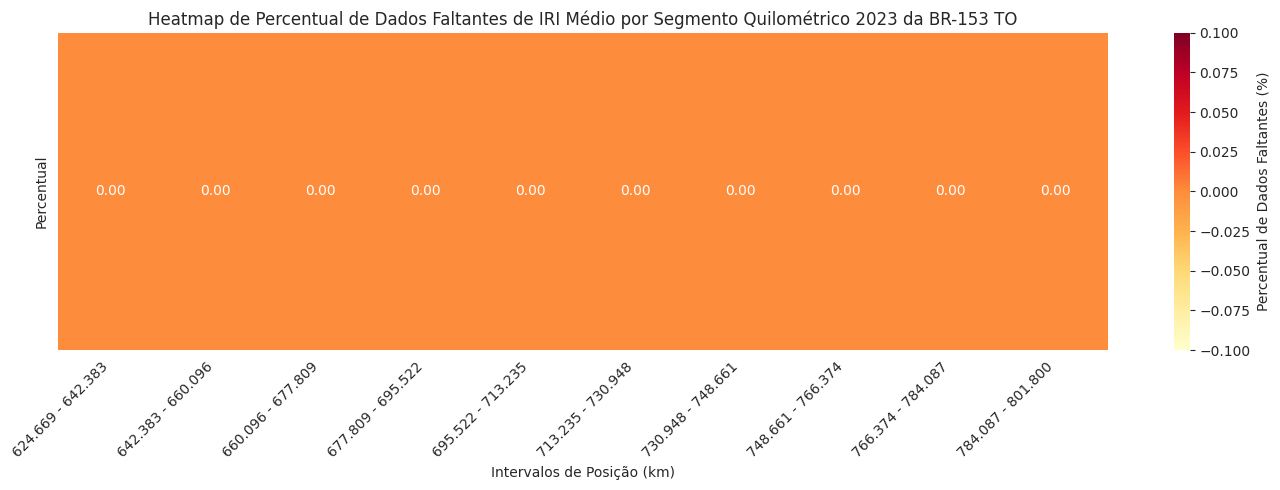

In [ ]:
caminho_arquivo = "Data/2023/ECVA_IRI_BR-153 TO.xlsx"
busca_parametro="Média por segmento"
busca_posicao="Início (km)"

label_titulo = "Heatmap de Percentual de Dados Faltantes de IRI Médio por Segmento Quilométrico 2023 da BR-153 TO"
label_eixo_x = "Intervalos de Posição (km)"
label_eixo_y = "Percentual"

def extrair_valores_e_posicoes(df, termo_y="IRI Médio", termo_x="Início (km)", ocorrencia=1):
    """
    Extrai valores de IRI Médio e suas respectivas posições quilométricas
    """
    # Encontrar headers de IRI Médio e Posição
    posicao_header_y = encontrar_header(df, termo_y, ocorrencia)
    posicao_header_x = encontrar_header(df, termo_x)

    if not posicao_header_y or not posicao_header_x:
        return None

    linha_header_y, coluna_header_y = posicao_header_y
    linha_header_x, coluna_header_x = posicao_header_x

    # Extrair valores de IRI Médio
    valores_y = df.iloc[linha_header_y + 1:, coluna_header_y]

    # Extrair posições quilométricas
    valores_x = df.iloc[linha_header_x + 1:, coluna_header_x]

    # Converter para numérico, forçando tratamento de erro
    valores_x = pd.to_numeric(valores_x, errors='coerce')
    valores_y = pd.to_numeric(valores_y, errors='coerce')

    # Criar DataFrame combinando os dois
    df_combinado = pd.DataFrame({
        'Posicao_km': valores_x,
        'IRI_Medio': valores_y
    })

    # Remover linhas com NaN em Posicao_km
    df_combinado = df_combinado.dropna(subset=['Posicao_km'])

    return df_combinado

def criar_heatmap_dados_faltantes(df_combinado, num_bins=10):
    """
    Cria um heatmap mostrando a distribuição de dados faltantes
    em diferentes segmentos quilométricos
    """
    # Total de células
    total_celulas = len(df_combinado)
    total_celulas_vazias = df_combinado['IRI_Medio'].isna().sum()

    # Definir intervalos de quilometragem
    km_min = df_combinado['Posicao_km'].min()
    km_max = df_combinado['Posicao_km'].max()
    bins = np.linspace(km_min, km_max, num_bins + 1)

    # Criar grupos de quilometragem
    df_combinado['Grupo_km'] = pd.cut(
        df_combinado['Posicao_km'],
        bins=bins,
        include_lowest=True
    )

    # Calcular dados faltantes por grupo
    dados_faltantes = df_combinado.groupby('Grupo_km').agg(
        Total=('IRI_Medio', 'count'),
        Dados_Faltantes=('IRI_Medio', lambda x: x.isna().sum()),
    ).reset_index()

    # Calcular percentual de dados faltantes em relação ao total GERAL
    dados_faltantes['Percentual_Faltantes'] = (
        dados_faltantes['Dados_Faltantes'] / total_celulas * 100
    ).round(2)

    # Preparar dados para heatmap
    heatmap_data = dados_faltantes['Percentual_Faltantes'].values.reshape(-1, 1)

    plt.figure(figsize=(14, 5))
    ax = sns.heatmap(
        heatmap_data.T,
        cmap='YlOrRd',
        annot=True,
        fmt='.2f',
        cbar_kws={'label': 'Percentual de Dados Faltantes (%)'}
    )

    # Customizar labels dos eixos
    ax.set_yticklabels([label_eixo_y])
    ax.set_xticklabels([f'{g.left:.3f} - {g.right:.3f}' for g in dados_faltantes['Grupo_km']], rotation=45, ha='right')

    plt.title(label_titulo)
    plt.xlabel(label_eixo_x)
    plt.tight_layout()

    return dados_faltantes, plt

# Carregar e processar dados
df_especifica = carregar_excel(caminho_arquivo, sheet_name=0)
df_combinado = extrair_valores_e_posicoes(df_especifica, busca_parametro, busca_posicao, ocorrencia=2)

if df_combinado is not None:
    # Criar heatmap
    dados_faltantes, fig = criar_heatmap_dados_faltantes(df_combinado)

    # Imprimir total de dados e total de dados faltantes
    total_celulas = len(df_combinado)
    total_celulas_vazias = df_combinado['IRI_Medio'].isna().sum()

    print(f"\nTotal de dados: {total_celulas}")
    print(f"Total de dados faltantes: {total_celulas_vazias}")
    print(f"Percentual geral de dados faltantes: {total_celulas_vazias / total_celulas * 100:.2f}%")

    plt.show()

    # Imprimir resumo dos dados faltantes
    #print("\nResumo de Dados Faltantes:")
    #print(dados_faltantes)
else:
    print("Não foi possível encontrar os headers necessários.")

As células faltantes podem ser observadas a partir do Heatmap acima que plota o Percentual de células faltantes em relação ao total de células da rodovia associado a trechos quilométricos de forma que a verificação de trechos com dados faltantes seja intuitiva. No entanto, no plot acima da BR-153 TO não foram observadas células faltantes de IRI médio do segmento (a cada 1 km), o que por sua vez é evidenciado com os trechos com percentuais zerados. Sendo assim, não há trechos com dados faltantes na BR-153 TO ao olhar para o IRI médio do segmento a cada 1 km.

In [ ]:
import pandas as pd
import numpy as np
import folium
import re
import os
from folium.plugins import MarkerCluster
from branca.element import Template, MacroElement
from IPython.display import display

class RodoviaParameterAnalyzer:
    def __init__(self, arquivo_excel, parametro="IRI", valor_limite=3.5, debug=False):
        """
        Inicializa o analisador de parâmetros de rodovia

        Args:
            arquivo_excel (str): Caminho para o arquivo Excel
            parametro (str): Nome do parâmetro a ser analisado (padrão: "IRI")
            valor_limite (float): Valor limite para determinar trechos críticos
            debug (bool): Se True, imprime informações detalhadas para depuração
        """
        self.arquivo_excel = arquivo_excel
        self.parametro = parametro
        self.valor_limite = valor_limite
        self.debug = debug
        self.excel = pd.ExcelFile(arquivo_excel)
        self.sheets = self.excel.sheet_names

        if self.debug:
            print(f"Arquivo carregado: {arquivo_excel}")
            print(f"Planilhas disponíveis: {self.sheets}")

    def encontrar_cabecalho(self, df, termo_busca, ocorrencia=1):
        """
        Encontra um cabeçalho na planilha, lidando com cabeçalhos aninhados e ocorrências múltiplas

        Args:
            df (DataFrame): DataFrame a ser pesquisado
            termo_busca (str): Termo para buscar nos cabeçalhos
            ocorrencia (int): Qual ocorrência retornar (padrão: 1 para primeira)

        Returns:
            tuple: (linha, coluna) da posição do cabeçalho encontrado
        """
        contador = 0
        padrao = re.compile(termo_busca, re.IGNORECASE)

        if self.debug:
            print(f"Buscando cabeçalho: '{termo_busca}' (ocorrência {ocorrencia})")

        # Busca em cada célula do DataFrame
        for i in range(min(20, len(df))):  # Aumentei para 20 linhas para capturar cabeçalhos mais abaixo
            for j in range(len(df.columns)):
                valor = str(df.iloc[i, j])
                if padrao.search(valor):
                    contador += 1
                    if self.debug:
                        print(f"  Encontrado '{valor}' na posição ({i}, {j}) - ocorrência {contador}")
                    if contador == ocorrencia:
                        return (i, j)

        raise ValueError(f"Cabeçalho contendo '{termo_busca}' (ocorrência {ocorrencia}) não encontrado!")

    def encontrar_longitude_por_latitude(self, df, posicao_latitude):
        """
        Encontra a coluna de longitude baseada na posição da latitude

        Args:
            df (DataFrame): DataFrame com os dados
            posicao_latitude (tuple): (linha, coluna) da posição do cabeçalho de latitude

        Returns:
            int: Índice da coluna de longitude
        """
        # Assume que a longitude está na próxima coluna após a latitude
        pos_long = posicao_latitude[1] + 1

        if self.debug:
            print(f"Posição da latitude: {posicao_latitude}")
            print(f"Posição inferida para longitude: ({posicao_latitude[0]}, {pos_long})")
            if pos_long < len(df.columns):
                print(f"  Valor na posição da longitude: {df.iloc[posicao_latitude[0], pos_long]}")

        return pos_long

    def extrair_dados_sheet(self, sheet_name,
                      termo_media=r"Média por segmento", ocorrencia_media=2,
                      termo_km=r"Início.*(km)",
                      termo_latitude=r"Latitude"):
        """
        Extrai dados relevantes de uma planilha específica, agrupando por quilômetro inteiro

        Args:
            sheet_name (str): Nome da aba da planilha
            termo_media (str): Regex para encontrar o cabeçalho de média
            ocorrencia_media (int): Qual ocorrência usar para o cabeçalho de média
            termo_km (str): Regex para encontrar o cabeçalho de quilometragem
            termo_latitude (str): Regex para encontrar o cabeçalho de latitude

        Returns:
            list: Lista de segmentos processados
        """
        if self.debug:
            print(f"\nProcessando planilha: '{sheet_name}'")

        # Carrega os dados da planilha
        df_raw = pd.read_excel(self.arquivo_excel, sheet_name=sheet_name, header=None)

        if self.debug:
            print(f"Dimensões da planilha: {df_raw.shape}")

        # Encontra as posições dos cabeçalhos
        pos_media = self.encontrar_cabecalho(df_raw, termo_media, ocorrencia_media)
        pos_km = self.encontrar_cabecalho(df_raw, termo_km)
        pos_lat = self.encontrar_cabecalho(df_raw, termo_latitude)
        pos_long = self.encontrar_longitude_por_latitude(df_raw, pos_lat)

        # Extrai os dados a partir das posições dos cabeçalhos
        linha_inicio = max(pos_media[0], pos_km[0], pos_lat[0]) + 1

        if self.debug:
            print(f"Posição do cabeçalho de média: {pos_media}")
            print(f"Posição do cabeçalho de km: {pos_km}")
            print(f"Posição do cabeçalho de latitude: {pos_lat}")
            print(f"Posição inferida para longitude: {pos_long}")
            print(f"Linha de início dos dados: {linha_inicio}")

        # Extrai as colunas relevantes
        valores_medios = []
        valores_km = []
        valores_lat = []
        valores_long = []

        # Loop para extrair os valores
        for i in range(linha_inicio, len(df_raw)):
            val_media = df_raw.iloc[i, pos_media[1]]
            val_km = df_raw.iloc[i, pos_km[1]]
            val_lat = df_raw.iloc[i, pos_lat[1]]
            val_long = df_raw.iloc[i, pos_long]

            # Verifica se os valores são válidos
            if pd.notna(val_media) and pd.notna(val_km) and pd.notna(val_lat) and pd.notna(val_long):
                valores_medios.append(val_media)
                valores_km.append(val_km)
                valores_lat.append(val_lat)
                valores_long.append(val_long)

                if self.debug and i < linha_inicio + 5:  # Mostra apenas as primeiras linhas
                    print(f"Linha {i}: Media={val_media}, KM={val_km}, Lat={val_lat}, Long={val_long}")

        if self.debug:
            print(f"Total de linhas válidas extraídas: {len(valores_medios)}")

        # Cria DataFrame com os valores extraídos
        df_dados = pd.DataFrame({
            'km': valores_km,
            'media': valores_medios,
            'latitude': valores_lat,
            'longitude': valores_long,
            'sheet': sheet_name
        })

        # Converte para numérico, garantindo que os tipos estejam corretos
        for col in ['km', 'media', 'latitude', 'longitude']:
            df_dados[col] = pd.to_numeric(df_dados[col], errors='coerce')

        # Remove linhas com valores nulos
        df_dados = df_dados.dropna()

        if self.debug:
            print(f"Dados após limpeza: {len(df_dados)} linhas")
            print("Amostra dos dados:")
            print(df_dados.head())

            # Verificar valores extremos para depuração
            for col in ['latitude', 'longitude']:
                print(f"Range de {col}: {df_dados[col].min()} a {df_dados[col].max()}")

        # Verifica se as coordenadas estão em formato válido
        valido = self.validar_coordenadas(df_dados)
        if not valido:
            if self.debug:
                print("AVISO: Coordenadas parecem estar em formato inválido!")

        # Adiciona coluna com o quilômetro inteiro para agrupamento exatamente como você descreveu
        # Por exemplo: 94,350 -> 94, 95,200 -> 95, etc.
        df_dados['km_inteiro'] = df_dados['km'].apply(lambda x: int(x))

        # Ordena os dados por quilômetro para garantir a sequência correta
        df_dados = df_dados.sort_values('km')

        # Agrupa por quilômetro inteiro
        segmentos = []
        for km_int, grupo in df_dados.groupby('km_inteiro'):
            # Calcula a média do parâmetro para o segmento
            media_segmento = grupo['media'].mean()

            # Define se o segmento é crítico
            is_critico = media_segmento > self.valor_limite

            # Obtém o primeiro e último quilômetro do segmento
            km_inicio = grupo['km'].min()
            km_fim = grupo['km'].max()

            # Garante que as coordenadas estão ordenadas por km para formar um caminho contínuo
            grupo_ordenado = grupo.sort_values('km')

            # Coleta todas as coordenadas deste grupo de quilômetro
            coordenadas = list(zip(grupo_ordenado['latitude'].tolist(), grupo_ordenado['longitude'].tolist()))

            # Garantir que temos coordenadas suficientes para desenhar uma linha
            if len(coordenadas) == 1:
                # Se temos apenas um ponto, criamos um segundo ponto próximo
                lat, lon = coordenadas[0]
                # Pequeno deslocamento para criar um segundo ponto visível
                coordenadas.append((lat + 0.0001, lon + 0.0001))

                if self.debug:
                    print(f"Segmento {km_int} tem apenas um ponto. Adicionando segundo ponto próximo.")

            segmentos.append({
                'km_inteiro': km_int,
                'km_inicio': km_inicio,
                'km_fim': km_fim,
                'media_parametro': media_segmento,
                'coordenadas': coordenadas,
                'is_critico': is_critico,
                'sheet': sheet_name,
                'num_pontos': len(coordenadas)  # Adiciona o número de pontos para depuração
            })

            if self.debug and len(segmentos) <= 3:  # Mostra apenas os primeiros segmentos
                print(f"\nSegmento {km_int}: {km_inicio}-{km_fim}, Média: {media_segmento:.2f}, Crítico: {is_critico}")
                print(f"  Número de coordenadas: {len(coordenadas)}")
                print(f"  Primeiras coordenadas: {coordenadas[:2]}")
                print(f"  Últimas coordenadas: {coordenadas[-2:] if len(coordenadas) > 1 else []}")

        if self.debug:
            print(f"Total de segmentos gerados: {len(segmentos)}")
            # Estatísticas sobre os segmentos
            total_criticos = sum(1 for s in segmentos if s['is_critico'])
            print(f"Total de segmentos críticos: {total_criticos}")
            print(f"Total de segmentos normais: {len(segmentos) - total_criticos}")

            # Estatísticas sobre pontos por segmento
            pontos_por_segmento = [s['num_pontos'] for s in segmentos]
            if pontos_por_segmento:
                print(f"Pontos por segmento - Mín: {min(pontos_por_segmento)}, " +
                      f"Máx: {max(pontos_por_segmento)}, " +
                      f"Média: {sum(pontos_por_segmento)/len(pontos_por_segmento):.1f}")

        return segmentos

    def validar_coordenadas(self, df):
        """
        Verifica se as coordenadas parecem estar em formato válido

        Args:
            df (DataFrame): DataFrame com colunas 'latitude' e 'longitude'

        Returns:
            bool: True se as coordenadas parecem válidas, False caso contrário
        """
        # Verificações básicas para latitude (-90 a 90) e longitude (-180 a 180)
        lat_valida = (-90 <= df['latitude'].min() <= 90) and (-90 <= df['latitude'].max() <= 90)
        long_valida = (-180 <= df['longitude'].min() <= 180) and (-180 <= df['longitude'].max() <= 180)

        # Para o Brasil, esperamos aproximadamente:
        # Latitude: entre -33 e +5
        # Longitude: entre -74 e -34
        brasil_lat = (-33 <= df['latitude'].min() <= 5) and (-33 <= df['latitude'].max() <= 5)
        brasil_long = (-74 <= df['longitude'].min() <= -34) and (-74 <= df['longitude'].max() <= -34)

        # Se as coordenadas estiverem invertidas, avisa
        if not brasil_lat and not brasil_long:
            invertidas = (-74 <= df['latitude'].min() <= -34) and (-33 <= df['longitude'].min() <= 5)
            if invertidas and self.debug:
                print("AVISO: Latitude e longitude podem estar invertidas!")

        return lat_valida and long_valida

    def processar_sheets(self, sheets_to_process=None):
        """
        Processa as planilhas selecionadas

        Args:
            sheets_to_process (list, optional): Lista de nomes de planilhas para processar.
                Se None, processa apenas a primeira. Se 'all', processa todas.

        Returns:
            list: Lista de segmentos processados de todas as planilhas
        """
        if sheets_to_process is None:
            # Processa apenas a primeira planilha
            sheets_to_process = [self.sheets[0]]
        elif sheets_to_process == 'all':
            # Processa todas as planilhas
            sheets_to_process = self.sheets

        todos_segmentos = []

        for sheet in sheets_to_process:
            try:
                segmentos = self.extrair_dados_sheet(sheet)
                todos_segmentos.extend(segmentos)
                print(f"Planilha '{sheet}' processada com sucesso: {len(segmentos)} segmentos encontrados.")
            except Exception as e:
                print(f"Erro ao processar planilha '{sheet}': {str(e)}")
                if self.debug:
                    import traceback
                    traceback.print_exc()

        if self.debug:
            print(f"\nTotal de segmentos em todas as planilhas: {len(todos_segmentos)}")

        return todos_segmentos

    def criar_mapa(self, segmentos, mostrar_todos=True, titulo=None):
        """
        Cria um mapa Folium com os segmentos da rodovia usando polilinhas

        Args:
            segmentos (list): Lista de segmentos processados
            mostrar_todos (bool): Se deve mostrar todos os segmentos ou apenas os críticos
            titulo (str, optional): Título para o mapa

        Returns:
            folium.Map: Mapa criado com os segmentos
        """
        if not segmentos:
            raise ValueError("Nenhum segmento disponível para criar o mapa!")

        if self.debug:
            print("\nCriando mapa...")
            print(f"Número de segmentos a processar: {len(segmentos)}")

        # Calcula o centro do mapa
        todas_lat = []
        todas_lng = []

        for seg in segmentos:
            for coord in seg['coordenadas']:
                todas_lat.append(coord[0])
                todas_lng.append(coord[1])

        if not todas_lat or not todas_lng:
            raise ValueError("Nenhuma coordenada válida encontrada nos segmentos!")

        centro_lat = sum(todas_lat) / len(todas_lat)
        centro_lng = sum(todas_lng) / len(todas_lng)

        if self.debug:
            print(f"Centro do mapa: Lat {centro_lat:.6f}, Long {centro_lng:.6f}")
            print(f"Range de latitude: {min(todas_lat):.6f} a {max(todas_lat):.6f}")
            print(f"Range de longitude: {min(todas_lng):.6f} a {max(todas_lng):.6f}")

        # Cria o mapa
        mapa = folium.Map(location=[centro_lat, centro_lng], zoom_start=12,
                          tiles='OpenStreetMap')

        # Adiciona título se fornecido
        if titulo:
            title_html = f'''
                <h3 align="center" style="font-size:16px"><b>{titulo}</b></h3>
            '''
            mapa.get_root().html.add_child(folium.Element(title_html))

        # Cria grupos para segmentos críticos e não críticos
        grupo_criticos = folium.FeatureGroup(name=f"Segmentos Críticos ({self.parametro} > {self.valor_limite})")
        grupo_normais = folium.FeatureGroup(name=f"Segmentos Normais ({self.parametro} ≤ {self.valor_limite})")

        total_criticos = 0
        total_normais = 0
        total_polilinhas = 0

        # Adiciona os segmentos ao mapa como polilinhas
        for i, seg in enumerate(segmentos):
            # Verifica se possui coordenadas válidas
            if not seg['coordenadas'] or len(seg['coordenadas']) < 2:
                if self.debug:
                    print(f"Segmento {i} ignorado: sem coordenadas suficientes")
                continue

            # Verifica se deve mostrar este segmento
            if not mostrar_todos and not seg['is_critico']:
                continue

            # Define a cor baseada na criticidade
            cor = 'red' if seg['is_critico'] else 'green'
            grupo = grupo_criticos if seg['is_critico'] else grupo_normais

            # Incrementa contadores para depuração
            if seg['is_critico']:
                total_criticos += 1
            else:
                total_normais += 1

            # Prepara informações para o tooltip e popup
            tooltip = f"{self.parametro}: {seg['media_parametro']:.2f} | KM: {seg['km_inicio']} - {seg['km_fim']}"
            popup_text = f"""
                <h4>Dados do Segmento</h4>
                <b>{self.parametro}:</b> {seg['media_parametro']:.2f}<br>
                <b>Limite:</b> {self.valor_limite}<br>
                <b>Status:</b> <span style="color:{'red' if seg['is_critico'] else 'green'};font-weight:bold">
                    {'CRÍTICO' if seg['is_critico'] else 'NORMAL'}</span><br>
                <b>Quilômetro:</b> {seg['km_inicio']} - {seg['km_fim']}<br>
                <b>Planilha:</b> {seg['sheet']}
            """

            popup = folium.Popup(popup_text, max_width=300)

            try:
                # Adiciona a polilinha representando o segmento
                folium.PolyLine(
                    seg['coordenadas'],
                    color=cor,
                    weight=5,  # Linha mais grossa para melhor visibilidade
                    opacity=0.8,
                    popup=popup,
                    tooltip=tooltip,
                    dash_array='5, 5' if seg['is_critico'] else None  # Linha tracejada para segmentos críticos
                ).add_to(grupo)

                total_polilinhas += 1

                # Adiciona marcadores nas extremidades dos segmentos críticos para melhor visualização
                if seg['is_critico']:
                    # Marcador no início do segmento crítico
                    folium.CircleMarker(
                        seg['coordenadas'][0],
                        radius=5,
                        color='red',
                        fill=True,
                        fill_color='red',
                        fill_opacity=0.7,
                        popup=f"Início: KM {seg['km_inicio']}",
                        tooltip=f"Início do segmento crítico (KM {seg['km_inicio']})"
                    ).add_to(grupo)

                    # Marcador no fim do segmento crítico
                    folium.CircleMarker(
                        seg['coordenadas'][-1],
                        radius=5,
                        color='red',
                        fill=True,
                        fill_color='red',
                        fill_opacity=0.7,
                        popup=f"Fim: KM {seg['km_fim']}",
                        tooltip=f"Fim do segmento crítico (KM {seg['km_fim']})"
                    ).add_to(grupo)

                if self.debug and i < 3:  # Depuração para os primeiros segmentos
                    print(f"Segmento {i+1}: {len(seg['coordenadas'])} pontos, {cor}, KM {seg['km_inicio']}-{seg['km_fim']}")
            except Exception as e:
                if self.debug:
                    print(f"Erro ao adicionar segmento {i+1}: {str(e)}")

        if self.debug:
            print(f"Total de segmentos críticos: {total_criticos}")
            print(f"Total de segmentos normais: {total_normais}")
            print(f"Total de polilinhas adicionadas: {total_polilinhas}")

        # Adiciona os grupos ao mapa
        grupo_criticos.add_to(mapa)
        grupo_normais.add_to(mapa)

        # Adiciona controle de camadas
        folium.LayerControl().add_to(mapa)

        # Adiciona legenda melhorada
        legenda_html = """
        <div style="position: fixed; bottom: 50px; left: 50px; width: 220px;
        border:2px solid grey; z-index:9999; font-size:14px;
        background-color:white; padding: 10px; border-radius: 6px; box-shadow: 0 0 10px rgba(0,0,0,0.2);">
        <h4 style="margin-top:0; margin-bottom:10px; text-align:center; font-weight:bold;">Legenda</h4>
        <div style="display:flex; align-items:center; margin-bottom:5px;">
            <div style="background-color:red; width:30px; height:4px; margin-right:10px; display:inline-block;"></div>
            <span>Crítico (""" + self.parametro + """ > """ + str(self.valor_limite) + """)</span>
        </div>
        <div style="display:flex; align-items:center; margin-bottom:5px;">
            <div style="background-color:green; width:30px; height:4px; margin-right:10px; display:inline-block;"></div>
            <span>Normal (""" + self.parametro + """ ≤ """ + str(self.valor_limite) + """)</span>
        </div>
        <div style="font-size:12px; color:#666; margin-top:5px;">* Passe o mouse sobre os segmentos para ver detalhes</div>
        </div>
        """

        legenda = MacroElement()
        legenda._template = Template(legenda_html)
        mapa.get_root().add_child(legenda)

        # Adiciona contador de segmentos críticos
        if total_criticos > 0:
            contador_html = f"""
            <div style="position: fixed; top: 20px; right: 20px; padding:10px;
            background-color:white; border:2px solid red; border-radius:5px; z-index:9999; font-size:14px;">
            <b>Segmentos Críticos:</b> {total_criticos}
            </div>
            """
            contador = MacroElement()
            contador._template = Template(contador_html)
            mapa.get_root().add_child(contador)

        return mapa

    def salvar_mapa(self, mapa, caminho_saida="mapa_rodovia.html"):
        """
        Salva o mapa em um arquivo HTML

        Args:
            mapa (folium.Map): Mapa a ser salvo
            caminho_saida (str): Caminho para salvar o arquivo HTML
        """
        mapa.save(caminho_saida)
        print(f"Mapa salvo em: {os.path.abspath(caminho_saida)}")

    def exibir_mapa(self, mapa):
        """
        Exibe o mapa diretamente no Jupyter Notebook

        Args:
            mapa (folium.Map): Mapa a ser exibido
        """
        # Exibe o mapa no Jupyter Notebook
        display(mapa)

    def adicionar_marcadores_teste(self, mapa, segmentos):
        """
        Adiciona marcadores de teste ao mapa para verificar se as coordenadas estão corretas

        Args:
            mapa (folium.Map): Mapa a ser modificado
            segmentos (list): Lista de segmentos

        Returns:
            folium.Map: Mapa com marcadores adicionados
        """
        grupo_teste = folium.FeatureGroup(name="Marcadores de Teste")

        # Adiciona um marcador em cada ponto do primeiro segmento
        if segmentos:
            primeiro_seg = segmentos[0]
            for i, coord in enumerate(primeiro_seg['coordenadas']):
                folium.Marker(
                    coord,
                    popup=f"Ponto {i+1} (KM {primeiro_seg['km_inicio'] + i*0.1:.3f})",
                    icon=folium.Icon(color='blue', icon='info-sign')
                ).add_to(grupo_teste)

            # Adiciona alguns marcadores para pontos críticos
            for seg in segmentos:
                if seg['is_critico']:
                    folium.Marker(
                        seg['coordenadas'][0],
                        popup=f"Crítico: {seg['media_parametro']:.2f}",
                        icon=folium.Icon(color='red', icon='warning-sign')
                    ).add_to(grupo_teste)

        grupo_teste.add_to(mapa)
        return mapa

analisador = RodoviaParameterAnalyzer(
    arquivo_excel="Data/2022/ECA_IRI_BR-080 GO.xlsx",
    parametro="IRI",
    valor_limite=3.5,
    debug=True  # Ativar modo de depuração
)

# Processar planilhas
segmentos = analisador.processar_sheets(sheets_to_process=None)  # ou None, ou lista específica

# Criar mapa com todos os segmentos e exibi-lo
mapa = analisador.criar_mapa(
    segmentos,
    mostrar_todos=True,
    titulo=f"Análise de {analisador.parametro} - Todos os Segmentos"
)

# Adicionar marcadores de teste para ajudar na depuração visual
mapa = analisador.adicionar_marcadores_teste(mapa, segmentos)

# Exibir o mapa
analisador.exibir_mapa(mapa)

Arquivo carregado: Data/2022/ECA_IRI_BR-080 GO.xlsx
Planilhas disponíveis: ['IRI CF1', 'IRI CF3', 'IRI DF1', 'Gráficos', 'Análise dos dados', 'Unifilar']

Processando planilha: 'IRI CF1'
Dimensões da planilha: (484, 16)
Buscando cabeçalho: 'Média por segmento' (ocorrência 2)
  Encontrado 'Média por segmento' na posição (4, 8) - ocorrência 1
  Encontrado 'Média por segmento' na posição (4, 12) - ocorrência 2
Buscando cabeçalho: 'Início.*(km)' (ocorrência 1)
  Encontrado 'Início (km)' na posição (4, 0) - ocorrência 1
Buscando cabeçalho: 'Latitude' (ocorrência 1)
  Encontrado 'Coordenadas geográficas
Latitude / Longitude' na posição (4, 2) - ocorrência 1
Posição da latitude: (4, 2)
Posição inferida para longitude: (4, 3)
  Valor na posição da longitude: nan
Posição do cabeçalho de média: (4, 12)
Posição do cabeçalho de km: (4, 0)
Posição do cabeçalho de latitude: (4, 2)
Posição inferida para longitude: 3
Linha de início dos dados: 5
Linha 5: Media=2, KM=94.35, Lat=-15.20848129, Long=-48.7

## 6. Anomalias e Irregularidades
**Nesta seção serão descritas metodologicamente possíveis anomalias identificadas nos dados, como trechos com valores de IRI faltantes ou acima do permitido, padrões de deterioração e possíveis explicações para as irregularidades observadas.**

A princípio, durante a análise exploratória, foram observados muitas células vazias nas planilhas de dados dos valores numéricos do IRI, inicialmente utilizando uma ferramenta de Motor de Busca apelidada de Auto Data Search Engine (ADSE) desenvolvida, um algoritmo de busca que varre as planilhas de dados buscando de forma automatizada pelo nome do parâmetro, extrai seus dados e contabiliza estatisticamente o número de células totais de um certo parâmetro, células vazias e numéricas para uma pré-análise dada um determinado trecho. Como demonstrado na exploração de dados (Seção 5.), principalmente com o exemplo de gráfico de Heatmap da BR-153 TO.

O uso do ADSE, neste caso, atua não só como um algoritmo de busca, mas também como uma pré-análise automatizada e ágil de um parâmetro, para agilizar possíveis anomalias e assim análises mais robustas postularem-se a seguir, como, por exemplo: análises gráficas de trechos criticos.

As possíveis anomalias, quando analisadas visualmente, plotadas em gráficos do tipo IRI (m/km) por Posição (km), os dados faltantes tornam-se descontinuidades, observada por exemplo como a seguir:

<img src="https://github.com/romulobrito/iri_ML/blob/master/Plots/IRI%20M%C3%A9dio%20por%20Quil%C3%B4metro%20(BR-153TO%20-%20km%20624,670%20-%20km%20801,860%20-%20Faixa%201%20-%20Sentido%20Crescente).png?raw=1" alt="IRI Médio por Quilômetro (BR-153TO - km 624,670 - km 801,860 - Faixa 1 - Sentido Crescente)" />

No plot acima de IRI Médio por Quilômetro da BR-153TO (2023) é possivel observar grandes descontinuidades, a mais notória no trecho km 662,400 até o km 677,300. Assim, evidenciando visualmente o que a pré-analise do ADSE apresentou anteriormente.

É de suma importância notar que para que os dados faltantes de certos trechos mostrem-se de fato como anomalias reais, não só seus respectivos IRIs devem evidenciarem-se como altos e ruins, mas quando também não existirem observações anotadas coerentes que justifiquem os altos índices ruins, assim tornando-se de fato irregulares e anômalas. Consequentemente, a última análise após os procedimentos anteriores trata-se de uma verificação da existência de observações anotadas para trechos críticos. Os trechos críticos podem ser visualizados principalmente como no exemplo — na Seção 5. — do gráfico de Heatmap e também com o gráfico de Estimativa de Densidade de Kernel de IRI Médio, assim, cabendo avaliar o periodo em que os dados encontram-se, para determinar se há tolerancia ou está de fato irregular.  

Há também a possibilidade de realizar-se um estudo mais profundo a respeito de trechos críticos, já que por padrão existem dados de geolocalizações de todos os trechos, por exemplo uma analise profunda para relacionar trechos críticos com dados climáticos da região atraves de APIs públicas, assim correlacionando índices ruins com danos de fortes chuvas ou fenômenos climáticos severos.

A análise detalhada dos dados na Seção 5 revelou padrões significativos de irregularidade na BR-153/TO e BR-060/GO, indicando trechos que apresentam índices de irregularidade (IRI) acima dos limites regulamentares. Esses achados são essenciais para entender a degradação da infraestrutura viária e orientar ações corretivas.

Principais Anomalias Identificadas (2022 e 2023):

1. Trechos Críticos com IRI Elevado

- A BR-153/TO apresentou diversos segmentos com IRI acima de 4,5 m/km, indicando pavimentação em condições inadequadas.
- A BR-080/GO mostrou setores com deterioração acelerada em áreas de alto tráfego, com valores médios superiores a 3,8 m/km.

2. Padrões de Deterioração ao Longo do Tempo

- Na BR-153/TO, observou-se um aumento gradual do IRI em segmentos que já estavam comprometidos em medições anteriores, reforçando a necessidade de manutenção preventiva.
- Na BR-080/GO, as irregularidades mostraram uma distribuição heterogênea, sugerindo que fatores ambientais e estruturais influenciam a degradação do pavimento.

3. Relação entre Tráfego e Condição da Via

- A correlação entre fluxo de veículos pesados e aumento do IRI foi particularmente evidente em trechos de interseções e acessos urbanos.
- O desgaste acelerado nesses pontos sugere que intervenções estruturais, como reforço do pavimento, podem ser necessárias.

4. Possíveis Inconsistências nos Dados

- Alguns pontos apresentaram variações abruptas no IRI sem justificativa aparente, o que pode indicar falhas na coleta de dados ou necessidade de calibração dos sensores.
- A revisão da metodologia de medição pode melhorar a precisão dos resultados e evitar falsas classificações de risco.

## 7. Conclusões da AED
**Nesta seção serão destacadas os principais achados e sugeridas direções para ações futuras, após a análise exploratória e possíveis anomalias dos dados, visando melhorias objetivas.**

As planilhas de dados mostraram-se bem estruturadas e simples para análises. As planilhas também possuem outros dados complementares (como dados geográficos, velocidade e dados brutos de IRI), mostrando-se muito completas e promovendo aberturas para outros tipos de análises e correlações de dados mais profundas através da inteligência artificial e outros sistemas. As ferramentas desenvolvidas para buscas, análises e plots de dados — que foram utilizadas para auxilio deste relatório — foram capazes de consumir os dados prontamente.

E com base nas análises realizadas, algumas conclusões importantes podem ser extraídas:

- A BR-153/TO e a BR-080/GO apresentam segmentos críticos com altos índices de irregularidade (em 2022 e 2023), exigindo priorização em futuras manutenções.
- A BR-080/GO apresentou uma evolução positiva desde 2022 até 2024 quando seus dados são visualizados temporalmente.
- A relação entre tráfego intenso e degradação do pavimento foi confirmada, especialmente em áreas com grande circulação de veículos pesados.
- A distribuição dos valores de IRI sugere que a degradação ocorre de forma não homogênea, reforçando a necessidade de abordagens específicas para cada rodovia e segmento.
- A existência de possíveis inconsistências nos dados destaca a importância de aperfeiçoar os processos de medição e validação dos indicadores.


## Análise de Clusters e Visualização Espacial dos Trechos
Nesta etapa, aplicamos técnicas de aprendizado não supervisionado para identificar padrões e grupos de trechos rodoviários com características semelhantes, utilizando o algoritmo KMeans para clustering. O objetivo é descobrir, sem rótulos prévios, se existem agrupamentos naturais de trechos com base em atributos como IRI, ano, rodovia e estado.

Primeiramente, realizamos o pré-processamento dos dados, transformando variáveis categóricas (rodovia e estado) em variáveis numéricas por meio de one-hot encoding, e normalizando os atributos numéricos (IRI e ano). Em seguida, aplicamos o KMeans com quatro clusters, permitindo que o algoritmo agrupe os trechos de acordo com suas semelhanças nos dados.

Para facilitar a visualização dos clusters em duas dimensões, utilizamos a técnica de Análise de Componentes Principais (PCA), que projeta os dados em um espaço bidimensional preservando a maior variabilidade possível. O gráfico resultante mostra claramente a separação dos clusters, indicando que existem grupos distintos de trechos rodoviários com padrões próprios de IRI e localização.

Além do KMeans, aplicamos o algoritmo DBSCAN, que é capaz de identificar grupos de alta densidade e detectar outliers (trechos muito diferentes dos demais). Os outliers detectados pelo DBSCAN são destacados e analisados separadamente, pois podem indicar trechos críticos ou com comportamento atípico.

Para entender o perfil de cada cluster, cruzamos os grupos encontrados com as variáveis rodovia, estado e classificação do trecho (Excelente, Bom, Regular, Crítico). Isso nos permite identificar, por exemplo, se determinados clusters concentram trechos mais problemáticos ou se estão associados a rodovias ou estados específicos.

Também geramos gráficos de dispersão do IRI ao longo do km inicial dos trechos, coloridos por cluster e por classificação. Esses gráficos permitem visualizar a distribuição espacial dos trechos críticos e excelentes ao longo da rodovia, facilitando a identificação de regiões que demandam maior atenção em termos de manutenção.

Construímos uma tabela resumo e um gráfico de barras empilhadas mostrando a proporção de cada classificação dentro de cada cluster KMeans. Essa análise revela que apenas um dos clusters concentra a maior parte dos trechos classificados como “Regular” ou “Crítico”, enquanto os demais são compostos quase exclusivamente por trechos “Excelente”. Isso reforça a utilidade do clustering para identificar hotspots de problemas e priorizar ações de manutenção.

In [ ]:
%pip install openpyxl

#### Sobre a Classificação dos Trechos e o PER como Ground Truth
A classificação dos trechos rodoviários utilizada neste trabalho (Excelente, Bom, Regular, Crítico) foi obtida a partir dos critérios estabelecidos pelo PER (Programa de Exploração da Rodovia). O PER é o documento oficial que define os parâmetros de desempenho e as faixas de valores aceitáveis para o Índice de Irregularidade Internacional (IRI) e outros indicadores de qualidade do pavimento, sendo utilizado por órgãos reguladores e concessionárias para a avaliação e fiscalização das condições das rodovias.

No contexto deste projeto, a classificação de cada trecho foi atribuída conforme as faixas de IRI definidas no PER, que são reconhecidas e adotadas oficialmente para tomada de decisão sobre manutenção, recuperação e aceitação dos segmentos rodoviários. Dessa forma, mesmo que a classificação seja derivada de uma regra baseada no IRI, ela reflete o padrão regulatório vigente e representa a “verdade oficial” (ground truth) utilizada no setor rodoviário brasileiro.

Portanto, ao utilizar essa classificação como variável alvo (target) nos modelos de machine learning, estamos treinando os algoritmos para aprender e replicar a política de avaliação adotada pelo órgão regulador, o que é plenamente justificável e alinhado com a prática do setor. É importante ressaltar que, caso existissem avaliações independentes feitas por especialistas ou auditorias externas, essas também poderiam ser utilizadas como ground truth, enriquecendo ainda mais a análise.

Estatísticas Descritivas do IRI:
count     1671.00
unique     232.00
top          1.88
freq        27.00
Name: IRI, dtype: float64


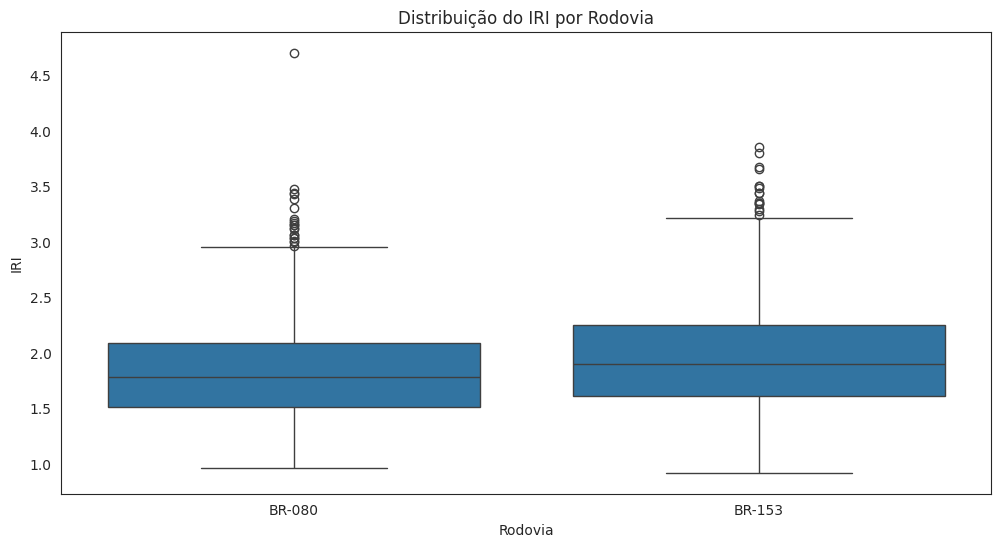

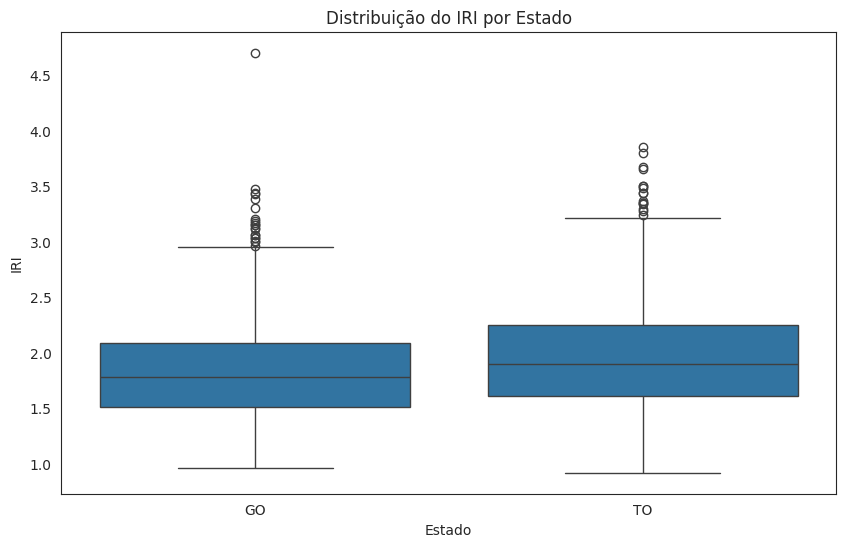

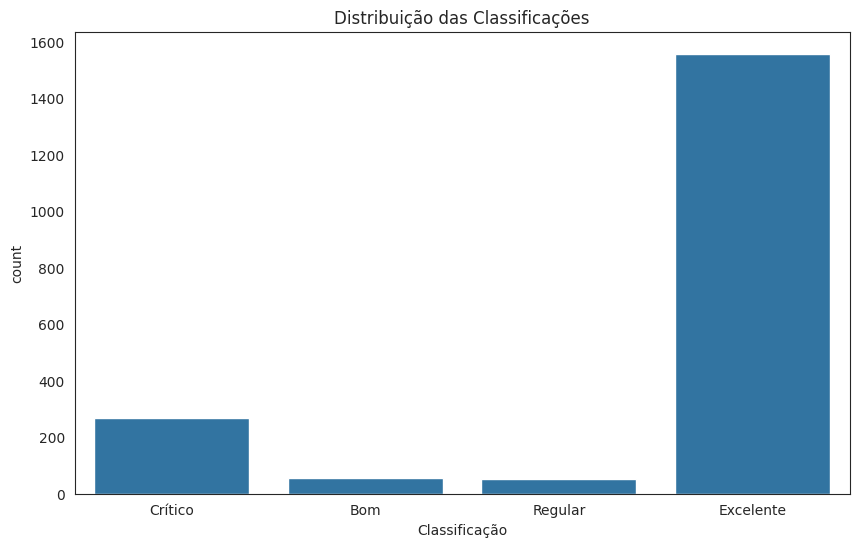

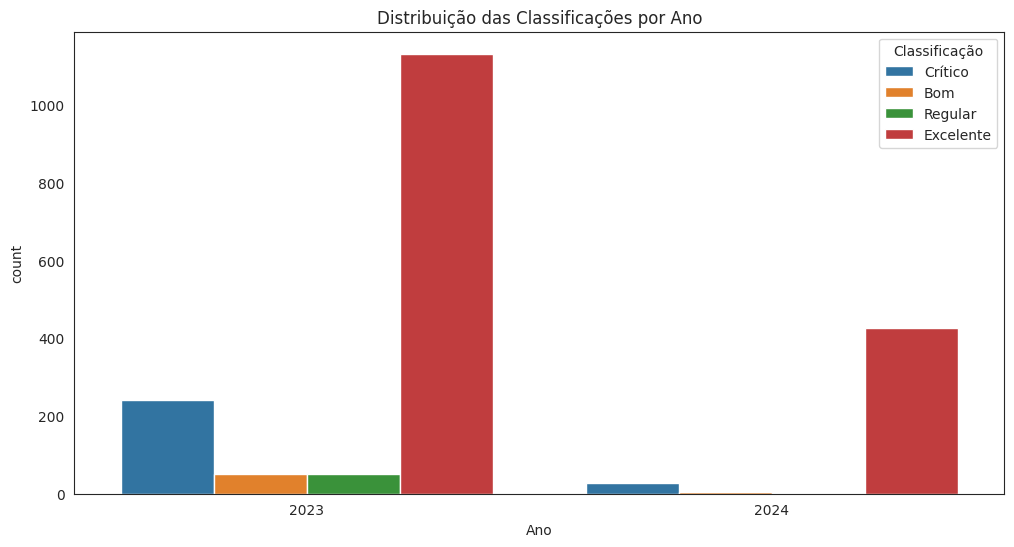

Valores ausentes por coluna:
IRI              262
Rodovia            0
Estado             0
Início (km)        1
Ano                0
Classificação      0
dtype: int64

Limites para valores discrepantes:
Limite inferior: 0.63
Limite superior: 3.08


In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path


# Importar bibliotecas de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

def carregar_excel(caminho_arquivo, termo_coluna="Início (km)"):
    df = pd.read_excel(caminho_arquivo, header=None)
    # Procurar a linha que contém o termo da coluna
    header_row = None
    rodovia = None
    estado = None
    for i in range(min(20, len(df))):
        # Busca rodovia/estado
        for j in range(df.shape[1]):
            cell = str(df.iat[i, j]).upper()
            if "BR-" in cell and "/" in cell:
                rodovia_estado = cell.replace(" ", "")
                rodovia, estado = rodovia_estado.split("/")
        if any(str(cell).strip().lower() == termo_coluna.lower() for cell in df.iloc[i]):
            header_row = i
    if header_row is not None:
        df.columns = df.iloc[header_row]
        df = df.drop(index=range(header_row+1))
        df = df.reset_index(drop=True)
    return df, rodovia, estado

def encontrar_header(df, termo="IRI Médio", ocorrencia=1):
    """
    Encontra dinamicamente a célula onde está localizado o termo desejado no DataFrame.
    """
    posicoes = df[df == termo].stack().index
    if posicoes.empty or len(posicoes) < ocorrencia:
        return None
    return posicoes[ocorrencia - 1]

def extrair_valores_abaixo(df, linha_header, coluna_header):
    """
    Extrai os valores abaixo do header localizado, na mesma coluna.
    """
    return df.iloc[linha_header + 1:, coluna_header]

def processar_arquivo_iri(caminho_arquivo):
    df, rodovia, estado = carregar_excel(caminho_arquivo)
    iri_col = None
    for col in df.columns:
        if str(col).strip().lower() == "iri médio":
            iri_col = col
            break
    if iri_col is not None:
        valores_iri = df[iri_col]
        # Se não encontrou, tenta pelo nome do arquivo
        if not rodovia or not estado:
            nome_arquivo = Path(caminho_arquivo).stem
            partes = nome_arquivo.split('_')
            for parte in partes:
                if 'BR-' in parte:
                    rodovia = parte
                elif parte in ['GO', 'TO']:
                    estado = parte
        if not rodovia:
            rodovia = 'BR-Desconhecida'
        if not estado:
            estado = 'Desconhecido'
        km_inicio = df['Início (km)'] if 'Início (km)' in df.columns else None
        df_iri = pd.DataFrame({
            'IRI': valores_iri,
            'Rodovia': rodovia,
            'Estado': estado
        })
        if km_inicio is not None:
            df_iri['Início (km)'] = km_inicio.values
        return df_iri
    return None


# Carregamento dos Dados
# Definir o caminho base dos dados
base_path = Path('Data')

# Lista para armazenar todos os DataFrames
dfs = []

# Processar arquivos de 2022 a 2024
for ano in ['2022', '2023', '2024']:
    ano_path = base_path / ano
    if ano_path.exists():
        for arquivo in ano_path.glob('ECVA_IRI_*.xlsx'):
            df = processar_arquivo_iri(arquivo)
            if df is not None:
                df['Ano'] = int(ano)
                dfs.append(df)

# Combinar todos os DataFrames
df_completo = pd.concat(dfs, ignore_index=True)


# Análise Exploratória
# Estatísticas descritivas
print("Estatísticas Descritivas do IRI:")
print(df_completo['IRI'].describe())

# Distribuição do IRI por rodovia
plt.figure(figsize=(12, 6))
sns.boxplot(x='Rodovia', y='IRI', data=df_completo)
plt.title('Distribuição do IRI por Rodovia')
plt.show()

# Distribuição do IRI por estado
plt.figure(figsize=(10, 6))
sns.boxplot(x='Estado', y='IRI', data=df_completo)
plt.title('Distribuição do IRI por Estado')
plt.show()


# Classificação dos Trechos
def classificar_iri(iri):
    """
    Classifica o trecho baseado no valor do IRI.
    """
    if iri < 2.7:
        return 'Excelente'
    elif iri < 3.0:
        return 'Bom'
    elif iri < 3.5:
        return 'Regular'
    else:
        return 'Crítico'

# Aplicar a classificação
df_completo['Classificação'] = df_completo['IRI'].apply(classificar_iri)

# Visualizar a distribuição das classes
plt.figure(figsize=(10, 6))
sns.countplot(x='Classificação', data=df_completo)
plt.title('Distribuição das Classificações')
plt.show()

# Análise por Ano

# Distribuição das classificações por ano
plt.figure(figsize=(12, 6))
sns.countplot(x='Ano', hue='Classificação', data=df_completo)
plt.title('Distribuição das Classificações por Ano')
plt.show()

# Pré-processamento de Dados

# Verificar valores ausentes
print("Valores ausentes por coluna:")
print(df_completo.isnull().sum())

# Remover valores ausentes
df_limpo = df_completo.dropna()

# Verificar valores discrepantes
Q1 = df_limpo['IRI'].quantile(0.25)
Q3 = df_limpo['IRI'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print(f"\nLimites para valores discrepantes:")
print(f"Limite inferior: {limite_inferior:.2f}")
print(f"Limite superior: {limite_superior:.2f}")



####  1. Distribuição do IRI por Rodovia
O boxplot mostra que tanto a BR-153 quanto a BR-080 apresentam valores medianos de IRI próximos, com a BR-080 levemente inferior. Ambas as rodovias possuem outliers, indicando trechos com IRI significativamente acima da média, o que pode sinalizar pontos críticos de irregularidade. A dispersão dos dados é semelhante, mas a BR-080 apresenta um outlier extremo, sugerindo um trecho com condição muito ruim.

####  2. Distribuição do IRI por Estado
A distribuição do IRI por estado (TO e GO) é bastante parecida, com valores medianos próximos e presença de outliers em ambos os estados. Isso indica que, independentemente do estado, a condição geral dos pavimentos é semelhante, mas existem trechos pontuais que fogem do padrão e merecem atenção.

####  3. Distribuição das Classificações
A maioria dos trechos foi classificada como “Excelente”, o que sugere que a malha rodoviária analisada está, em geral, em boas condições. No entanto, há uma quantidade considerável de trechos “Crítico”, além de alguns “Bom” e “Regular”. Isso evidencia a necessidade de monitoramento contínuo e intervenções pontuais.

####   4. Distribuição das Classificações por Ano
O gráfico mostra que, em 2023, houve uma maior diversidade de classificações, com presença significativa de trechos “Crítico”, “Bom” e “Regular”. Em 2024, a maioria dos trechos foi classificada como “Excelente”, sugerindo uma possível melhoria nas condições ou uma diferença no volume de dados coletados entre os anos.


### Etapa de Machine Learning (ML)

Após a análise exploratória e o pré-processamento dos dados, foi realizada uma etapa de Machine Learning supervisionado com o objetivo de prever a condição do pavimento (classificação dos trechos) a partir dos dados disponíveis. O processo seguiu as seguintes etapas:

#### 1. **Preparação dos Dados**
Selecionamos como variáveis de entrada (features) o valor do IRI (Índice de Irregularidade Internacional) e o ano da medição. A variável alvo (target) foi a classificação do trecho, previamente definida conforme os critérios do PER (Programa de Exploração da Rodovia), resultando nas classes: Excelente, Bom, Regular e Crítico.

Antes do treinamento, a variável alvo foi codificada numericamente utilizando o LabelEncoder, transformando as classes em valores inteiros para facilitar o processamento pelos algoritmos de ML. Em seguida, os dados foram divididos em conjuntos de treino (80%) e teste (20%) de forma aleatória, garantindo que a avaliação do modelo fosse feita em dados não vistos durante o treinamento.

#### 2. **Construção e Treinamento dos Modelos**
Foram utilizados dois algoritmos de classificação:
- **Random Forest Classifier:** Um modelo de ensemble baseado em múltiplas árvores de decisão, robusto a ruídos e capaz de capturar relações não lineares entre as variáveis.
- **Support Vector Machine (SVM):** Um modelo que busca encontrar hiperplanos ótimos para separar as classes, eficiente em problemas com margens bem definidas.

Ambos os modelos foram inseridos em pipelines que incluem a padronização dos dados numéricos (StandardScaler), garantindo que as variáveis de entrada estejam na mesma escala e evitando viés no treinamento.

#### 3. **Avaliação dos Modelos**
Após o treinamento, os modelos foram avaliados no conjunto de teste. Foram gerados relatórios de classificação (classification_report), que incluem métricas como precisão, recall, f1-score e acurácia para cada classe. Além disso, foram plotadas as matrizes de confusão, permitindo visualizar a quantidade de acertos e erros de cada modelo para cada classe.

#### 4. **Análise de Importância das Variáveis**
No caso do Random Forest, foi analisada a importância relativa de cada variável de entrada para a decisão do modelo. O gráfico de importância das features mostrou que o IRI é, de longe, o principal fator para a classificação dos trechos, enquanto o ano tem influência mínima.

#### 5. **Visualização das Fronteiras de Decisão**
Para melhor compreensão do comportamento dos modelos, foi gerada uma visualização das fronteiras de decisão do Random Forest, mostrando como o modelo separa as diferentes classes no espaço das variáveis IRI e ano.

#### 6. **Análise de Erros**
Ao final foi realizada uma análise dos erros de classificação, identificando quais classes são mais confundidas pelo modelo e calculando a taxa de erro global.



Resultados do Random Forest:
              precision    recall  f1-score   support

         Bom       1.00      1.00      1.00        11
     Crítico       0.00      0.00      0.00         0
   Excelente       1.00      1.00      1.00       313
     Regular       1.00      1.00      1.00        11

    accuracy                           1.00       335
   macro avg       0.75      0.75      0.75       335
weighted avg       1.00      1.00      1.00       335



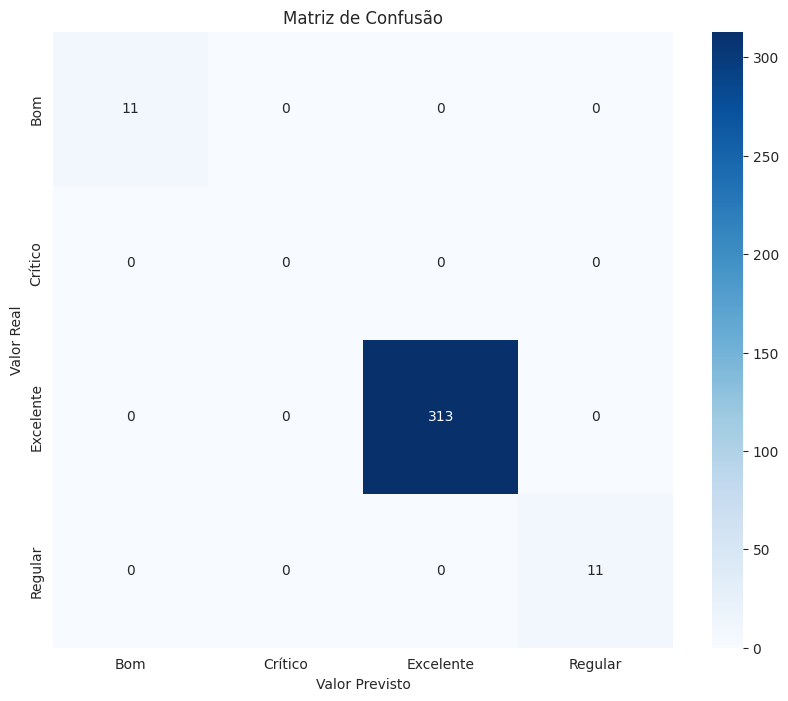


Resultados do SVM:
              precision    recall  f1-score   support

         Bom       1.00      0.91      0.95        11
     Crítico       0.00      0.00      0.00         0
   Excelente       1.00      1.00      1.00       313
     Regular       1.00      1.00      1.00        11

    accuracy                           1.00       335
   macro avg       0.75      0.73      0.74       335
weighted avg       1.00      1.00      1.00       335



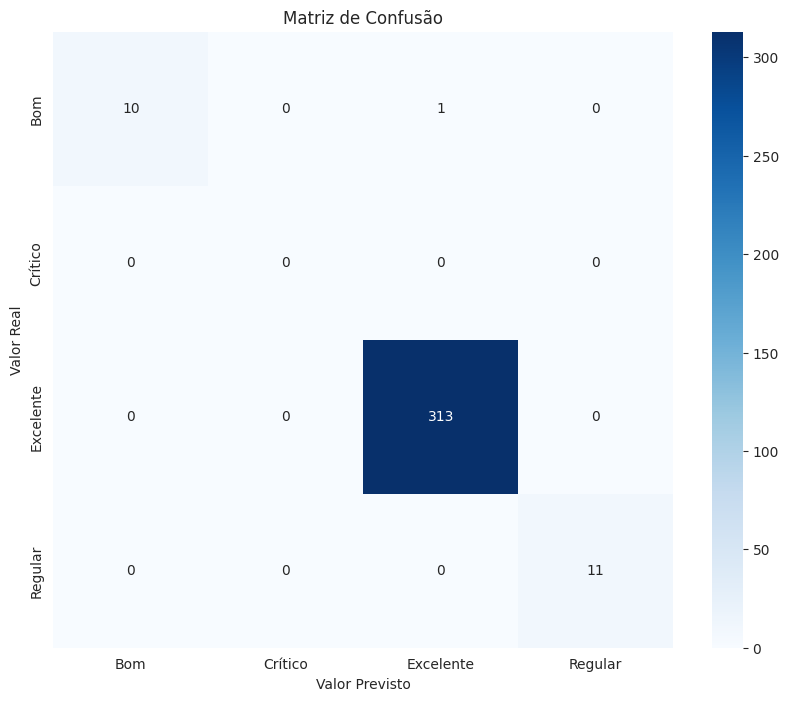

In [ ]:
# Machine Learning

# Preparação dos Dados para ML
# Preparar features e target
X = df_limpo[['IRI', 'Ano']]  # Features
y = df_limpo['Classificação']  # Target

# Codificar variáveis categóricas
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Treinamento dos Modelos

# Criar pipeline com StandardScaler e RandomForest
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Criar pipeline com StandardScaler e SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(kernel='rbf', random_state=42))
])

# Treinar modelos
pipeline_rf.fit(X_train, y_train)
pipeline_svm.fit(X_train, y_train)


# Avaliação dos Modelos
# Função para plotar matriz de confusão
# Lista de todas as classes possíveis
all_labels = list(range(len(le.classes_)))

# Função para plotar matriz de confusão considerando todas as classes
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusão')
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Previsto')
    plt.show()

# Avaliar Random Forest
y_pred_rf = pipeline_rf.predict(X_test)
print("Resultados do Random Forest:")
print(classification_report(y_test, y_pred_rf, labels=all_labels, target_names=le.classes_))
plot_confusion_matrix(y_test, y_pred_rf, le.classes_)

# Avaliar SVM
y_pred_svm = pipeline_svm.predict(X_test)
print("\nResultados do SVM:")
print(classification_report(y_test, y_pred_svm, labels=all_labels, target_names=le.classes_))
plot_confusion_matrix(y_test, y_pred_svm, le.classes_)




#### 5. Matriz de Confusão dos Modelos
As matrizes de confusão para Random Forest e SVM mostram que os modelos conseguem classificar corretamente quase todos os exemplos, com pouquíssimos erros. Isso era esperado, já que a classificação é derivada diretamente do IRI, principal variável de entrada. O modelo Random Forest, em especial, apresenta desempenho perfeito nos dados de teste.

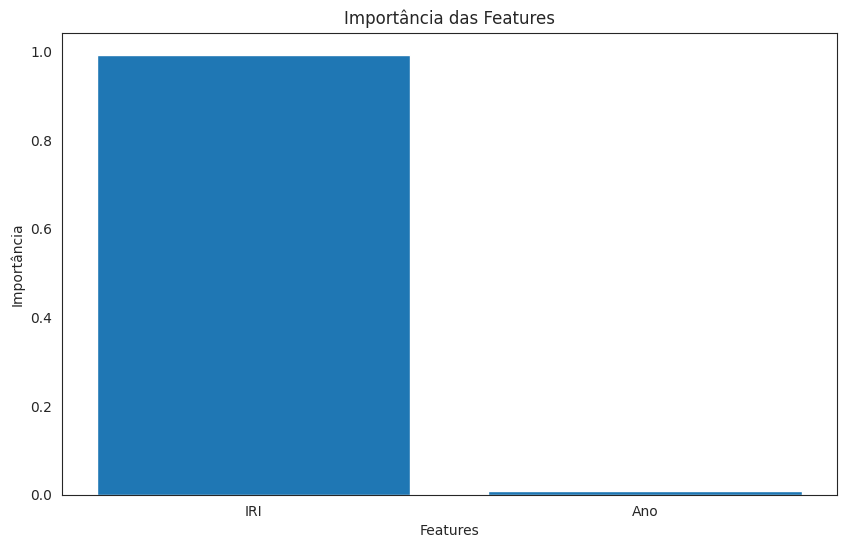

In [ ]:
#  Análise de Importância das Features (Random Forest)

# Obter importância das features do Random Forest
feature_importance = pipeline_rf.named_steps['classifier'].feature_importances_
feature_names = X.columns

# Plotar importância das features
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importance)
plt.title('Importância das Features')
plt.xlabel('Features')
plt.ylabel('Importância')
plt.show()

#### 6. Importância das Features
O gráfico de importância das features deixa claro que o IRI é, de longe, o fator mais relevante para a classificação dos trechos. O ano tem influência praticamente nula, reforçando que a condição do pavimento é determinada quase exclusivamente pelo valor do IRI.

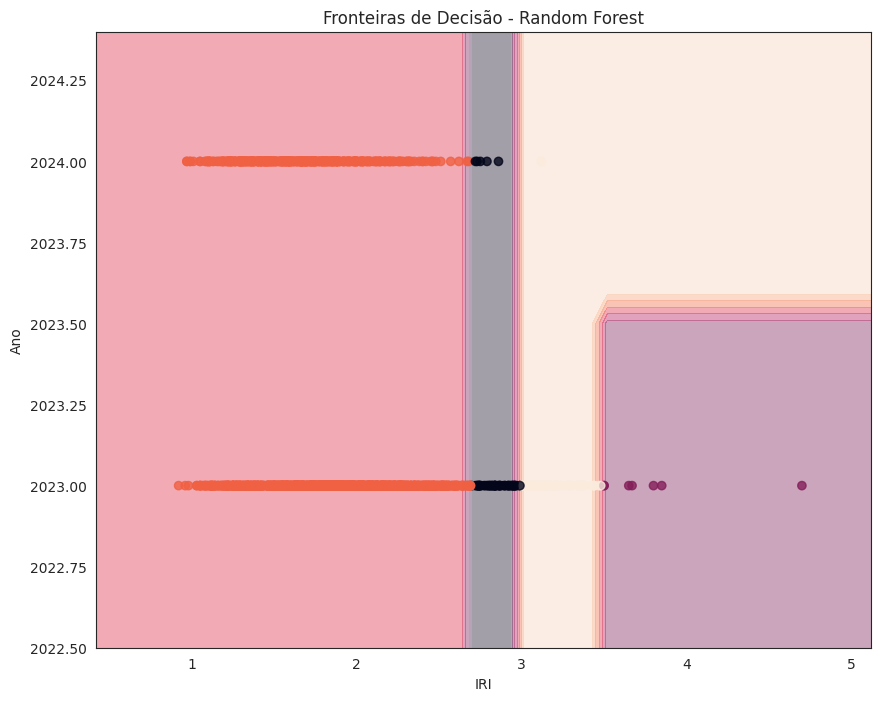

Estatísticas por Classificação:
                   mean       std  count
Classificação                           
Bom            2.841273  0.083756     55
Crítico            3.81  0.414568      7
Excelente      1.810911  0.386235   1558
Regular        3.171961  0.147106     51

Percentuais por Classificação:
Classificação
Excelente    93.237582
Bom           3.291442
Regular       3.052065
Crítico       0.418911
Name: proportion, dtype: float64

Análise de Erros de Classificação:
Total de erros: 0
Taxa de erro: 0.00%

Distribuição dos Erros:
Series([], Name: count, dtype: int64)


In [ ]:
# Visualização das Decisões do Modelo

# Criar grid para visualização
def plot_decision_boundary(X, y, model, title):
    # Criar grid de pontos
    x_min, x_max = X['IRI'].min() - 0.5, X['IRI'].max() + 0.5
    y_min, y_max = X['Ano'].min() - 0.5, X['Ano'].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))

    # Fazer previsões para cada ponto do grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plotar
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X['IRI'], X['Ano'], c=y, alpha=0.8)
    plt.title(title)
    plt.xlabel('IRI')
    plt.ylabel('Ano')
    plt.show()

# Plotar fronteiras de decisão para Random Forest
plot_decision_boundary(X, y_encoded, pipeline_rf, 'Fronteiras de Decisão - Random Forest')

# Calcular estatísticas por classificação
print("Estatísticas por Classificação:")
print(df_limpo.groupby('Classificação')['IRI'].agg(['mean', 'std', 'count']))

# Calcular percentuais por classificação
print("\nPercentuais por Classificação:")
print(df_limpo['Classificação'].value_counts(normalize=True) * 100)


# %%
# Análise das previsões do melhor modelo (Random Forest)
df_test = X_test.copy()
df_test['Classificação_Real'] = le.inverse_transform(y_test)
df_test['Classificação_Prevista'] = le.inverse_transform(y_pred_rf)

# Análise de erros
erros = df_test[df_test['Classificação_Real'] != df_test['Classificação_Prevista']]
print("\nAnálise de Erros de Classificação:")
print(f"Total de erros: {len(erros)}")
print(f"Taxa de erro: {len(erros)/len(df_test)*100:.2f}%")

# Distribuição dos erros
print("\nDistribuição dos Erros:")
print(erros['Classificação_Real'].value_counts())

#### 7. Fronteiras de Decisão
A visualização das fronteiras de decisão do Random Forest mostra que as classes são separadas principalmente por faixas de IRI, com pouca ou nenhuma influência do ano. Isso confirma que a classificação segue regras bem definidas baseadas no IRI.

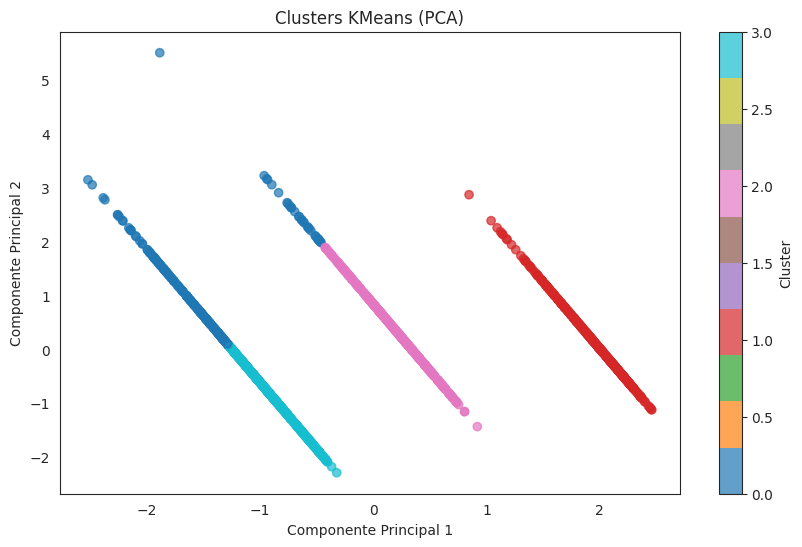

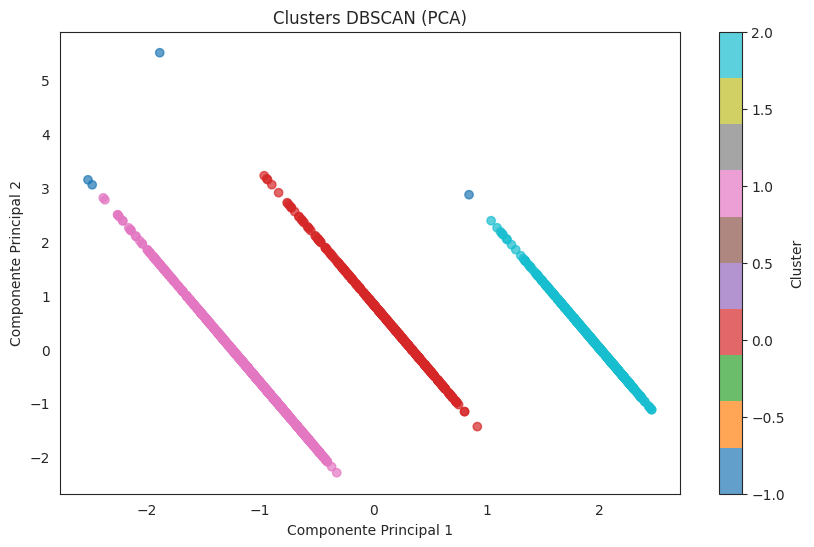


Resumo dos clusters KMeans:
                     IRI                     Ano
                    mean       std count    mean
Cluster_KMeans                                  
0               2.668527  0.395801   258  2023.0
1               1.680208  0.363962   432  2024.0
2               1.909093  0.377647   397  2023.0
3               1.701832  0.303932   584  2023.0

Distribuição dos clusters DBSCAN:
Cluster_DBSCAN
 1    808
 2    431
 0    428
-1      4
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

# Seleção de features para clustering
features = ['IRI', 'Ano', 'Rodovia', 'Estado']
df_cluster = df_limpo[features].copy()

# One-hot encoding para variáveis categóricas
categorical = ['Rodovia', 'Estado']
numeric = ['IRI', 'Ano']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(), categorical),
    ('num', StandardScaler(), numeric)
])

X_cluster = preprocessor.fit_transform(df_cluster)

# --- KMeans ---
kmeans = KMeans(n_clusters=4, random_state=42)
labels_kmeans = kmeans.fit_predict(X_cluster)
df_cluster['Cluster_KMeans'] = labels_kmeans

# Visualização dos clusters (PCA para 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)
plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap='tab10', alpha=0.7)
plt.title('Clusters KMeans (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

# --- DBSCAN ---
dbscan = DBSCAN(eps=0.5, min_samples=10)
labels_dbscan = dbscan.fit_predict(X_cluster)
df_cluster['Cluster_DBSCAN'] = labels_dbscan

plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_dbscan, cmap='tab10', alpha=0.7)
plt.title('Clusters DBSCAN (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

# --- Análise dos clusters ---
print('\nResumo dos clusters KMeans:')
print(df_cluster.groupby('Cluster_KMeans').agg({'IRI':['mean','std','count'], 'Ano':'mean'}))
print('\nDistribuição dos clusters DBSCAN:')
print(df_cluster['Cluster_DBSCAN'].value_counts())

#### 8. Clusters KMeans e DBSCAN (PCA)
Os gráficos de clusters mostram que os dados podem ser agrupados em grupos bem definidos, com base nas variáveis analisadas. O KMeans separa os trechos em quatro clusters, enquanto o DBSCAN identifica três grupos principais e alguns outliers. Isso sugere que existem padrões naturais nos dados, possivelmente relacionados a diferentes rodovias, estados ou condições de pavimento.


Distribuição de rodovias por cluster (KMeans):
Cluster_KMeans  Rodovia
0               BR-153     226
                BR-080      32
1               BR-080     432
2               BR-080     397
3               BR-153     584
Name: count, dtype: int64

Distribuição de estados por cluster (KMeans):
Cluster_KMeans  Estado
0               TO        226
                GO         32
1               GO        432
2               GO        397
3               TO        584
Name: count, dtype: int64

Distribuição de classificações por cluster (KMeans):
Cluster_KMeans  Classificação
0               Excelente        157
                Regular           50
                Bom               44
                Crítico            7
1               Excelente        426
                Bom                5
                Regular            1
2               Excelente        391
                Bom                6
3               Excelente        584
Name: count, dtype: int64

Distribuição de rodo

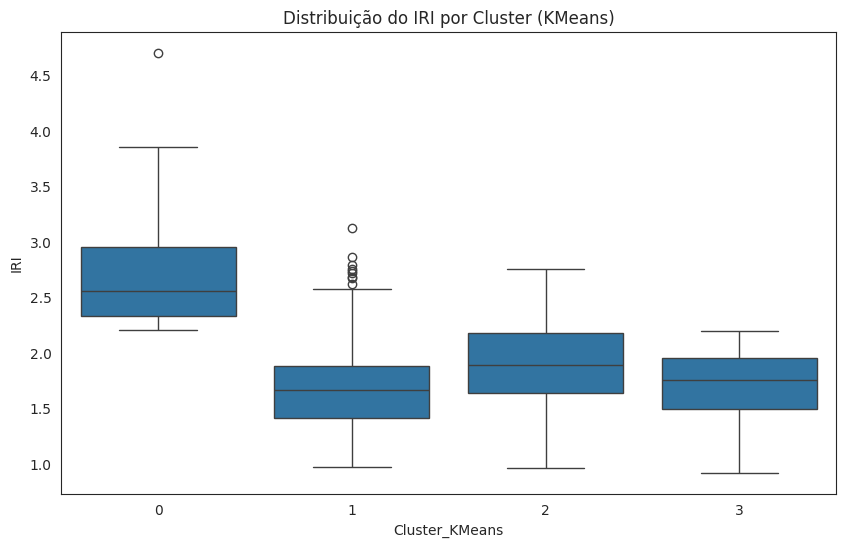

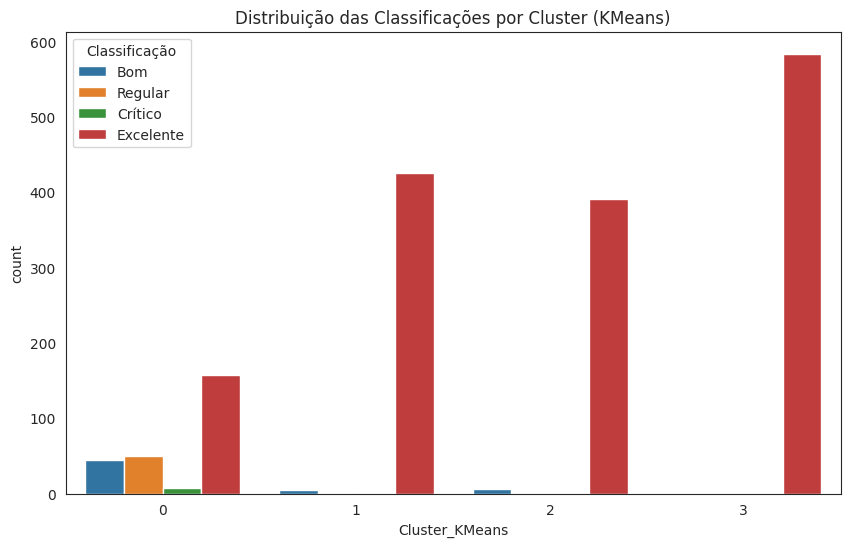

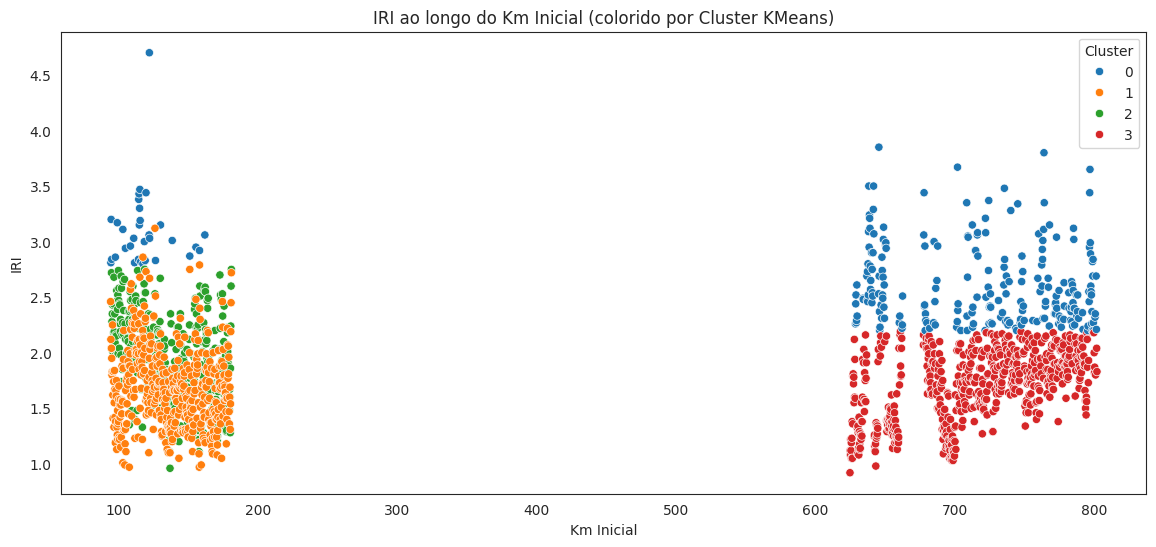

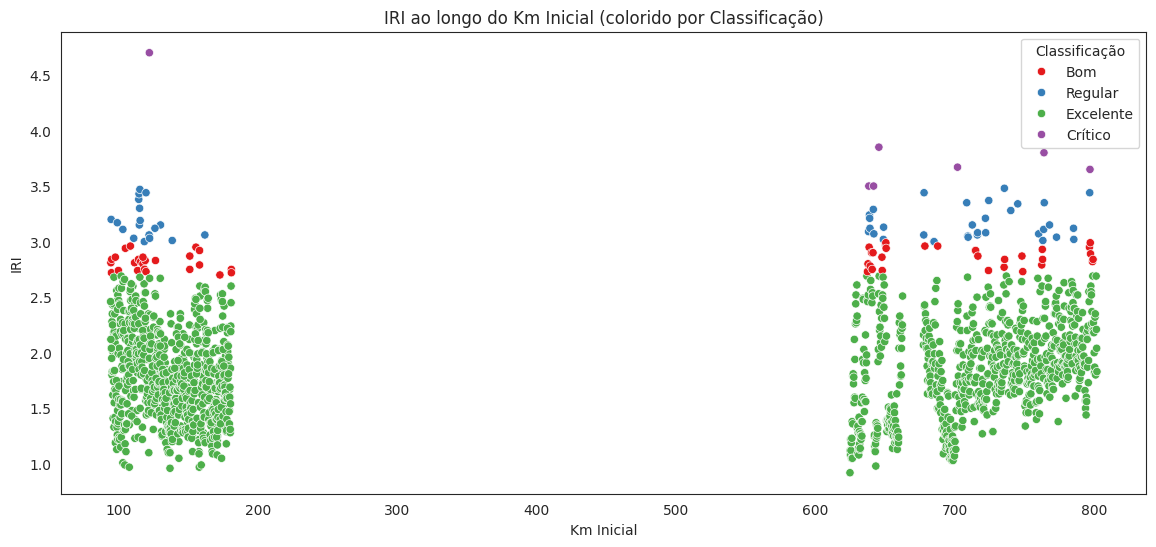


Proporção de cada classificação por cluster KMeans:
Classificação        Bom   Crítico  Excelente   Regular
Cluster_KMeans                                         
0               0.170543  0.027132   0.608527  0.193798
1               0.011574  0.000000   0.986111  0.002315
2               0.015113  0.000000   0.984887  0.000000
3               0.000000  0.000000   1.000000  0.000000


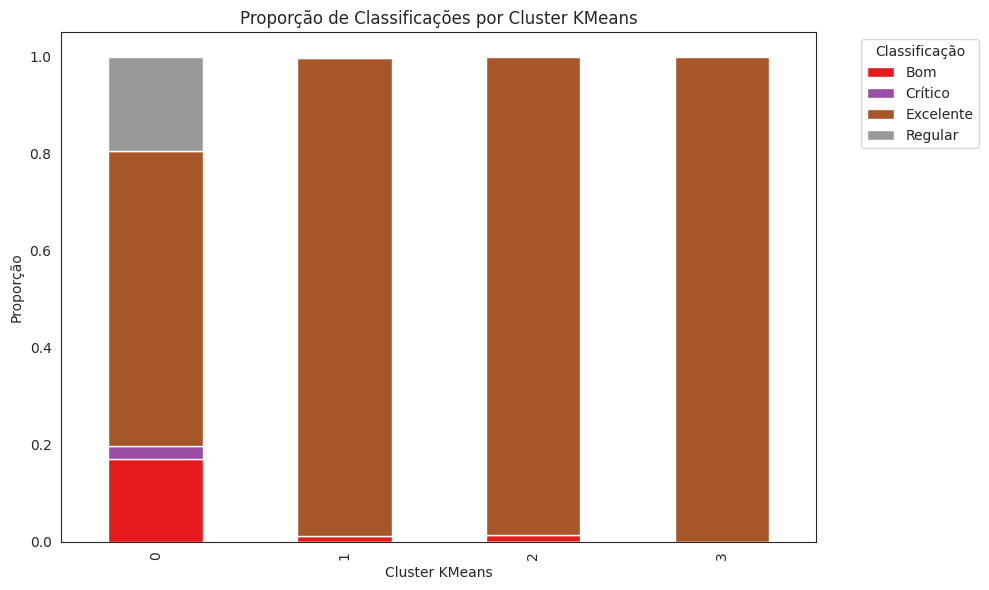

In [ ]:

# Análise  dos Clusters
# Cruzar clusters KMeans com rodovia, estado e classificação
print('\nDistribuição de rodovias por cluster (KMeans):')
print(df_cluster.groupby('Cluster_KMeans')['Rodovia'].value_counts())

print('\nDistribuição de estados por cluster (KMeans):')
print(df_cluster.groupby('Cluster_KMeans')['Estado'].value_counts())

if 'Classificação' in df_limpo.columns:
    df_cluster['Classificação'] = df_limpo['Classificação'].values
    print('\nDistribuição de classificações por cluster (KMeans):')
    print(df_cluster.groupby('Cluster_KMeans')['Classificação'].value_counts())

# Cruzar clusters DBSCAN com rodovia, estado e classificação
print('\nDistribuição de rodovias por cluster (DBSCAN):')
print(df_cluster.groupby('Cluster_DBSCAN')['Rodovia'].value_counts())

print('\nDistribuição de estados por cluster (DBSCAN):')
print(df_cluster.groupby('Cluster_DBSCAN')['Estado'].value_counts())

if 'Classificação' in df_cluster.columns:
    print('\nDistribuição de classificações por cluster (DBSCAN):')
    print(df_cluster.groupby('Cluster_DBSCAN')['Classificação'].value_counts())

# Análise dos outliers do DBSCAN
outliers = df_cluster[df_cluster['Cluster_DBSCAN'] == -1]
print(f'\nTotal de outliers detectados pelo DBSCAN: {len(outliers)}')
if not outliers.empty:
    print('Resumo dos outliers:')
    print(outliers[['IRI', 'Ano', 'Rodovia', 'Estado', 'Classificação']])


plt.figure(figsize=(10,6))
sns.boxplot(x='Cluster_KMeans', y='IRI', data=df_cluster)
plt.title('Distribuição do IRI por Cluster (KMeans)')
plt.show()

if 'Classificação' in df_cluster.columns:
    plt.figure(figsize=(10,6))
    sns.countplot(x='Cluster_KMeans', hue='Classificação', data=df_cluster)
    plt.title('Distribuição das Classificações por Cluster (KMeans)')
    plt.show()

if 'Início (km)' in df_limpo.columns:
    df_cluster['Km_Inicio'] = df_limpo['Início (km)'].values
else:
    print('Coluna "Início (km)" não encontrada no DataFrame.')


if 'Km_Inicio' in df_cluster.columns:
    plt.figure(figsize=(14,6))
    sns.scatterplot(x='Km_Inicio', y='IRI', hue='Cluster_KMeans', data=df_cluster, palette='tab10')
    plt.title('IRI ao longo do Km Inicial (colorido por Cluster KMeans)')
    plt.xlabel('Km Inicial')
    plt.ylabel('IRI')
    plt.legend(title='Cluster')
    plt.show()

    # Gráfico de dispersão: Classificação vs Km_Inicio
    if 'Classificação' in df_cluster.columns:
        plt.figure(figsize=(14,6))
        sns.scatterplot(x='Km_Inicio', y='IRI', hue='Classificação', data=df_cluster, palette='Set1')
        plt.title('IRI ao longo do Km Inicial (colorido por Classificação)')
        plt.xlabel('Km Inicial')
        plt.ylabel('IRI')
        plt.legend(title='Classificação')
        plt.show()


if 'Classificação' in df_cluster.columns:
    resumo_clusters = pd.crosstab(df_cluster['Cluster_KMeans'], df_cluster['Classificação'], normalize='index')
    print('\nProporção de cada classificação por cluster KMeans:')
    print(resumo_clusters)

    # Gráfico de barras empilhadas
    resumo_clusters.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set1')
    plt.title('Proporção de Classificações por Cluster KMeans')
    plt.xlabel('Cluster KMeans')
    plt.ylabel('Proporção')
    plt.legend(title='Classificação', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

#### 9. Distribuição do IRI e Classificações por Cluster
O boxplot do IRI por cluster mostra que apenas um dos clusters concentra a maior parte dos trechos com IRI elevado (e, consequentemente, mais “Regular” e “Crítico”). Os demais clusters são compostos quase exclusivamente por trechos “Excelente”. O gráfico de barras empilhadas reforça esse achado, mostrando que a maioria dos clusters é homogênea em relação à classificação, exceto um, que apresenta maior diversidade e concentra os trechos problemáticos.
#### 10. Distribuição Espacial (Km Inicial)
Os gráficos de dispersão do IRI ao longo do km inicial, coloridos por cluster e por classificação, permitem identificar regiões específicas da rodovia onde se concentram os trechos críticos ou regulares. Isso é fundamental para priorizar intervenções e planejar ações de manutenção de forma mais eficiente.